In [1]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import time 
import math
from collections import deque

#### goap classes 1

In [2]:
class WorldState:
    def __init__(self, dictionary):
        self.__dictionary=dictionary
    def __str__(self):
        return str(self.__dictionary)
    def set_parameter(self,param_name,new_value):
        if param_name in self.__dictionary.keys():
            self.__dictionary[param_name]=new_value
        else:
            raise ValueError('ERROR: Failed set_parameter. World state does not contain parameter '+str(param_name))
    def increment_parameter(self,param_name,inc):
        if param_name in self.__dictionary.keys():
            self.__dictionary[param_name]+=inc
        else:
            raise ValueError('ERROR: Failed increment_parameter. World state does not contain parameter '+str(param_name))
    def get_state(self):
        return dict(self.__dictionary)
    def __add__(self, other):
        added=dict(other.__dictionary)
        ans=dict(self.__dictionary)
        for k in added.keys():
            if (k not in self.__dictionary.keys()):
                raise ValueError('ERROR:  Failed __add__. World state does not contain parameter '+str(k))
            else:
                ans[k]+=added[k]
        return WorldState(ans)
    def __lshift__(self, other):
        sett=dict(other.__dictionary)
        ans=dict(self.__dictionary)
        for k in sett.keys():
            if (k not in self.__dictionary.keys()):
                raise ValueError('ERROR:  Failed __lshift__. World state does not contain parameter '+str(k))
            else:
                ans[k]=sett[k]
        return WorldState(ans)
    def __lt__(self, other):
        less=dict(other.__dictionary)
        ans=dict(self.__dictionary)
        flag=True
        for k in less.keys():
            if (k not in self.__dictionary.keys()):
                raise ValueError('ERROR:  Failed __lt__. World state does not contain parameter '+str(k))
            else:
                if (ans[k]<less[k]):
                    continue
                else:
                    flag=False
                    break
        return flag
    def __gt__(self, other):
        more=dict(other.__dictionary)
        ans=dict(self.__dictionary)
        flag=True
        for k in more.keys():
            if (k not in self.__dictionary.keys()):
                raise ValueError('ERROR:  Failed __gt__. World state does not contain parameter '+str(k))
            else:
                if (ans[k]>more[k]):
                    continue
                else:
                    flag=False
                    break
        return flag
    def __eq__(self, other):
        equal=dict(other.__dictionary)
        ans=dict(self.__dictionary)
        flag=True
        for k in equal.keys():
            if (k not in self.__dictionary.keys()):
                raise ValueError('ERROR:  Failed __eq__. World state does not contain parameter '+str(k))
            else:
                if (ans[k]==equal[k]):
                    continue
                else:
                    flag=False
                    break
        return flag
    def is_one_of(self, other):
        possible=dict(other.__dictionary)
        ans=dict(self.__dictionary)
        flag=True
        for k in possible.keys():
            if (k not in self.__dictionary.keys()):
                raise ValueError('ERROR:  Failed is_one_of. World state does not contain parameter '+str(k))
            else:
                if (ans[k] in possible[k]):
                    continue
                else:
                    flag=False
                    break
        return flag

#### goap cost

In [64]:
# defence_cost_weight=1.5
# attack_cost_weight=1

defence_cost_weight=1
attack_cost_weight=1.5

# defence_cost_weight=1
# attack_cost_weight=1

# defence_cost_weight=1
# attack_cost_weight=1.05

#class DoubleCost(Cost):
class DoubleCost():
    def __init__(self, defence_cost=0.0, attack_cost=0.0):
        self.__defence=float(defence_cost)
        self.__attack=float(attack_cost)
    def __str__(self):
        return 'Defence value: '+str(self.__defence)+', Attack value: '+str(self.__attack)
    def increment(self, defence_inc=0.0, attack_inc=0.0):
        self.__defence+=float(defence_inc)
        self.__attack+=float(attack_inc)
    def __add__(self, other):
        return DoubleCost(defence_cost=self.__defence+other.__defence, attack_cost=self.__attack+other.__attack)
    def value(self):
        return defence_cost_weight*self.__defence+attack_cost_weight*self.__attack
    def def_value(self):
        v=self.__defence
        return v
    def atk_value(self):
        v=self.__attack
        return v

#### goap classes 2

In [4]:
class Action:
    def __init__(self, cost=DoubleCost(), pre_less=None, pre_equals=None, pre_more=None, post_set=None, post_inc=None, name=''):
        self.__pre_less=pre_less
        self.__pre_equals=pre_equals
        self.__pre_more=pre_more
        self.__post_set=post_set
        self.__post_inc=post_inc
        self.__cost=cost
        self.__name=str(name)
    def __str__(self):
        return 'Action: '+self.__name+', Cost: '+str(self.__cost)+'\n  Preconditions:  equals: '+str(self.__pre_equals)+', less: '+str(self.__pre_less)+', more: '+str(self.__pre_more)+'\n  Effects:  set: '+str(self.__post_set)+', increment: '+str(self.__post_inc)
    def is_achievable_given(self, pre_worldstate):
        if (self.__pre_less is not None):
            if (pre_worldstate<self.__pre_less):
                pass
            else:
                return False
        if (self.__pre_equals is not None):
            if (pre_worldstate==self.__pre_equals):
                pass
            else:
                return False
        if (self.__pre_more is not None):
            if (pre_worldstate>self.__pre_more):
                pass
            else:
                return False
        return True
    def take_action_on(self, pre_worldstate):
        post_worldstate=WorldState(pre_worldstate.get_state())
        if (self.__post_set is not None):
            post_worldstate=post_worldstate<<self.__post_set
        if (self.__post_inc is not None):
            post_worldstate=post_worldstate+self.__post_inc
        return post_worldstate
    def cost(self):
        c=self.__cost
        return c
    def name(self):
        c=self.__name
        return c

    
class Constraint:
    def __init__(self, less=None, more=None, one_of=None):
        self.__less=less
        self.__more=more
        self.__one_of=one_of
    def is_satisfied_by(self, worldstate):
        if (self.__less is not None):
            if (worldstate<self.__less):
                pass
            else:
                return False
        if (self.__more is not None):
            if (worldstate>self.__more):
                pass
            else:
                return False
        if (self.__one_of is not None):
            if (worldstate.is_one_of(self.__one_of)):
                pass
            else:
                return False
        return True
    
class Goal:
    def __init__(self, less=None, more=None, equals=None):
        self.__less=less
        self.__more=more
        self.__equals=equals
    def is_achieved_in(self, worldstate):
        if (self.__less is not None):
            if (worldstate<self.__less):
                pass
            else:
                return False
        if (self.__more is not None):
            if (worldstate>self.__more):
                pass
            else:
                return False
        if (self.__equals is not None):
            if (worldstate==self.__equals):
                pass
            else:
                return False
        return True
    

class Node:
    def __init__(self, parent, depth, cost, worldstate, action):
        self.parent=parent
        self.depth=depth
        self.cost=cost
        self.worldstate=worldstate
        self.action=action

In [5]:
from collections import deque
import pandas as pd

class Planner_df:
    def __init__(self, actions, worldstate, goal, constraint=Constraint(), zero_cost=DoubleCost(0), max_depth=5):
        if (constraint.is_satisfied_by(worldstate) is False):
            raise ValueError('ERROR: Failed Planner __init__. Initial world state '+str(worldstate)+' does not satisfy constraints.')
        if (max_depth<1):
            raise ValueError('ERROR: Failed Planner __init__. Max depth value of '+str(max_depth)+'is too small.')
        self.__actions=actions
        self.__worldstate=worldstate
        self.__goal=goal
        self.__constraint=constraint
        self.__zero_cost=zero_cost
        self.__max_depth=int(max_depth)
        self.__leaves=[]
    def plan(self):
        start_node=Node(parent=None, depth=0, cost=self.__zero_cost, worldstate=self.__worldstate, action=None)
        self.__build_graph(cur_node=start_node)
        if (len(self.__leaves)==0):
            return None
        costs=[]
        paths=[]
        lengths=[]
        actions=[]
        def_values=[]
        atk_values=[]
        for i in range(self.__max_depth):
            actions.append([])
        for leaf in self.__leaves:
            costs.append(leaf.cost.value())
            def_values.append(leaf.cost.def_value())
            atk_values.append(leaf.cost.atk_value())
            path=deque()
            while (leaf!=start_node):
                path.appendleft(leaf.action.name())
                leaf=leaf.parent
            paths.append(list(path))
            leng=len(path)
            lengths.append(leng)
            for i in range(leng):
                actions[i].append(path[i])
            for i in range(leng,self.__max_depth):
                actions[i].append(None)
            
        ans=pd.DataFrame()
        ans['path']=paths
        ans['cost']=costs
        ans['attack_cost']=atk_values
        ans['defence_cost']=def_values
        ans['length']=lengths
        for i in range(self.__max_depth):
            ans['action_'+str(i)]=actions[i]
        ans.sort_values(by=['cost', 'length'], ascending=False, inplace=True, ignore_index=True)
        return ans
    
    def __build_graph(self, cur_node):
        if (self.__goal.is_achieved_in(cur_node.worldstate)):
            self.__leaves.append(cur_node)
            #return None
        if (cur_node.depth==self.__max_depth):
            return None
        for action in self.__actions:
            if (action.is_achievable_given(cur_node.worldstate)):
                new_worldstate=action.take_action_on(cur_node.worldstate)
                if (self.__constraint.is_satisfied_by(new_worldstate)):
                    self.__build_graph(cur_node=Node(parent=cur_node,
                                                 depth=cur_node.depth+1,
                                                 cost=cur_node.cost+action.cost(),
                                                 worldstate=new_worldstate,
                                                 action=action))

#### map functions

In [6]:
def get_color(celltype):
    if celltype==0: # border
        return 'forestgreen'
    if celltype==1: # nothing
        return '1.0'
    if celltype==2: # swamp
        return 'magenta'
    if celltype==3: # bridge
        return 'peru'
    if celltype==4: # water
        return 'skyblue'
    if celltype==5: # rough terrain
        return '0.75'
    if celltype==6: # for indicating
        return 'orange'
    return 'black' 

def step_cost(celltype):
    if celltype==0: # border
        return None
    if celltype==1: # nothing
        return 1
    if celltype==2: # swamp
        return None
    if celltype==3: # bridge
        return 1
    if celltype==4: # water
        return None
    if celltype==5: # rough terrain
        return 2
    raise Exception(f'Something went wrong: celltype is not in 0..5\ncelltype is {celltype}')

def get_label_array():
    return np.full((36,29),'',dtype=object)

def plot_cells_and_labels(cells, labels=get_label_array()):
    fig, ax= plt.subplots(figsize=(8.5,10))
    ax.set_xlim(left=0, right=290)
    ax.set_ylim(bottom=0, top=360)
    for i in range(36):
        for j in range(29):
            rect=Rectangle((10*j, 10*i), 10, 10, linewidth=0.75, edgecolor='0.2', facecolor=get_color(cells[36-i-1][j]))
            ax.add_patch(rect)
            ax.text(10*j + 1,10*i+1 + 1,labels[36-i-1][j],size=12)
    plt.show();

def get_map():
    cells=np.ones(shape=(36,29))

    #red camp forest
    cells[0:3, 5]=np.zeros(shape=(3,))
    cells[0:3, 16]=np.zeros(shape=(3,))
    cells[2:7, 2]=np.zeros(shape=(5,))
    cells[2:7, 9]=np.zeros(shape=(5,))
    cells[6, 3:9]=np.zeros(shape=(6,))
    cells[2, 10:17]=np.zeros(shape=(7,))

    #forest above river 
    cells[9, 2:9]=np.zeros(shape=(7,))
    cells[5, 13:19]=np.zeros(shape=(6,))
    cells[8, 13:17]=np.zeros(shape=(4,))
    cells[9:11, 13]=np.zeros(shape=(2,))
    cells[2, -5:]=np.zeros(shape=(5,))
    cells[6, -7:-2]=np.zeros(shape=(5,))
    cells[2:7, -7]=np.zeros(shape=(5,))

    #swamp above river
    cells[12:14, :6]=2*np.ones(shape=(2,6))
    cells[12:14, 10:14]=2*np.ones(shape=(2,4))
    cells[11, 12:16]=2*np.ones(shape=(4,))
    cells[12,14]=2
    cells[7, 13:17]=2*np.ones(shape=(4,))
    cells[7:11, -9:-6]=2*np.ones(shape=(4,3))

    #rough above river
    cells[6, 13:17]=5*np.ones(shape=(4,))
    cells[2:6, 3:5]=5*np.ones(shape=(4,2))

    #river
    cells[11:13, 16:]=4*np.ones(shape=(2,13))
    cells[14:16, :15]=4*np.ones(shape=(2,15))
    cells[13, 14:17]=4*np.ones(shape=(3,))
    cells[12,15]=4
    cells[14,15]=4

    #bridges
    cells[10:14,-2]=3*np.ones(shape=(4,))
    cells[10:14,-11]=3*np.ones(shape=(4,))

    #swamp below river
    cells[14:20,-8:-3]=2*np.ones(shape=(6,5))
    cells[16:18,4:8]=2*np.ones(shape=(2,4))
    cells[16:18,9:16]=2*np.ones(shape=(2,7))
    cells[15,15]=2
    cells[-5:-1,-7]=2*np.ones(shape=(4,))

    #rough below river
    cells[15:20,-3:]=5*np.ones(shape=(5,3))
    cells[-11:-8, -12:-7]=5*np.ones(shape=(3,5))

    #bottom left forest
    cells[16:21, 0]=np.zeros(shape=(5,))
    cells[20, 1:6]=np.zeros(shape=(5,))
    cells[16:22, 8]=np.zeros(shape=(6,))
    cells[22:25, 0]=np.zeros(shape=(3,))
    cells[-3:, 2]=np.zeros(shape=(3,))
    cells[-6:-4, 2:5]=np.zeros(shape=(2,3))
    cells[-8:-3, 7]=np.zeros(shape=(5,))
    cells[-14:-8, 2:9]=np.zeros(shape=(6,7))
    cells[-13:-11, 8]=np.ones(shape=(2,))
    cells[-11:-8, 3:5]=np.ones(shape=(3,2))
    cells[-13, 4:7]=np.ones(shape=(3,))
    cells[-12:-9, 6]=np.ones(shape=(3,))
    cells[-10,7]=1
    cells[-14,4]=1

    #blue camp forest
    cells[-5:, 10]=np.zeros(shape=(5,))
    cells[-5, 11:13]=np.zeros(shape=(2,))
    cells[-5:-2, 13]=np.zeros(shape=(3,))
    cells[-3, 14:16]=np.zeros(shape=(2,))
    cells[-8:-3, 15]=np.zeros(shape=(5,))
    cells[-8, 16:21]=np.zeros(shape=(5,))
    cells[-8:-2, 21]=np.zeros(shape=(6,))
    cells[-5:, 18]=np.zeros(shape=(5,))
    cells[-5, 17]=0

    #bottom right forest
    cells[-3:, -5]=np.zeros(shape=(3,))
    cells[-6:-2, -3]=np.zeros(shape=(4,))
    cells[-9:-5, -5]=np.zeros(shape=(4,))
    cells[-9, -4:]=np.zeros(shape=(4,))
    cells[-14:-9, -1]=np.zeros(shape=(5,))
    cells[-14:-10, -4]=np.zeros(shape=(4,))
    cells[-11, -9:-4]=np.zeros(shape=(5,))
    cells[-10, -9]=0
    cells[-16:-13, -7]=np.zeros(shape=(3,))

    #forest below river
    cells[15:20, -11]=np.zeros(shape=(5,))
    cells[14:19, -13]=np.zeros(shape=(5,))
    cells[13, -12]=0
    cells[21, -17:-10]=np.zeros(shape=(7,))
    cells[25, -17:-14]=np.zeros(shape=(3,))
    cells[24, -17]=0
    return cells

#### cellfinding functions

##### zone building

In [7]:
def reachable_cells_labels(y_and_x=(15,19),stepmax=6,cells=get_map()):
    (y,x)=y_and_x
    deltas=[[-1,0], [0,1], [1,0], [0,-1]]
    ymax=cells.shape[0]
    xmax=cells.shape[1]
    neighbors=deque()
    neighbors.appendleft(((y,x),0))
    visited=(stepmax+1)*np.ones(cells.shape).astype(int)
    visited[y,x]=0

    while len(neighbors)>0:
        ((y,x),step)=neighbors.pop()
        for [dy,dx] in deltas:
            if (y+dy>-1) and (y+dy<ymax) and (x+dx>-1) and (x+dx<xmax): # valid index
                cost=step_cost(cells[y+dy,x+dx])
                if cost is not None and step+cost<stepmax+1 and visited[y+dy,x+dx]>step+cost:
                    neighbors.appendleft(((y+dy,x+dx),step+cost))
                    visited[y+dy,x+dx]=step+cost

    visited=visited.astype(str)                
    visited=np.where(visited!=str(stepmax+1),visited,'')
    return visited

def split_cells_by_quarter(reachable_cells_labels, quarter, y_and_x=(15,19)):
    rcl_indices=np.where(reachable_cells_labels!='')
    rcl_indices=np.array([rcl_indices[0],rcl_indices[1]]).T
    (y_start,x_start)=y_and_x
    if quarter==1:
        quarter_indices=[[y,x] for [y,x] in rcl_indices if y<y_start and x>=x_start]
    elif quarter==2:
        quarter_indices=[[y,x] for [y,x] in rcl_indices if y>=y_start and x>x_start]
    elif quarter==3:
        quarter_indices=[[y,x] for [y,x] in rcl_indices if y>y_start and x<=x_start]
    elif quarter==4:
        quarter_indices=[[y,x] for [y,x] in rcl_indices if y<=y_start and x<x_start]
    else :
        raise Exception(f'Something went wrong: quarter is not in 1..4\nquarter is {quarter}')
    quarter_labels=get_label_array()
    for [y,x] in quarter_indices:
        quarter_labels[y,x]=reachable_cells_labels[y,x]
    return quarter_labels

def split_cells_by_half(reachable_cells_labels, half, y_and_x=(15,19)):
    rcl_indices=np.where(reachable_cells_labels!='')
    rcl_indices=np.array([rcl_indices[0],rcl_indices[1]]).T
    (y_start,x_start)=y_and_x
    if half==1:
        half_indices=[[y,x] for [y,x] in rcl_indices if x>x_start or (x==x_start and y<y_start)]
    elif half==2:
        half_indices=[[y,x] for [y,x] in rcl_indices if x<x_start or (x==x_start and y>y_start)]
    else :
        raise Exception(f'Something went wrong: half is not in 1..2\nhalf is {half}')
    half_labels=get_label_array()
    for [y,x] in half_indices:
        half_labels[y,x]=reachable_cells_labels[y,x]
    return half_labels

def deltayx(i):
    i=int(i)
    k=math.floor((math.sqrt(8*(i//4)+1)-1)/2)
    rem=i-k*(k+1)*2
    quart=rem//(k+1)
    inquart=rem%(k+1)
    if quart==0:
        dy=-1*(k+1)+inquart
        dx=inquart
    elif quart==1:
        dy=inquart
        dx=k+1-inquart
    elif quart==2:
        dy=k+1-inquart
        dx=-inquart
    elif quart==3:
        dy=-inquart
        dx=-1*(k+1)+inquart
    else:
        raise Exception(f'Something went wrong: quart is not in 0..3\ni is {i}\nk is {k}\nrem is {rem}\nquart is {quart}\ninquart is {inquart}')
    return (dy,dx)

def list_of_covered_dx_equals_zero(radius, dy):
    l=[(lci,0) for lci in range(dy,radius+1)]
    for upper_iter in range(dy+1,radius):
        lower_iter=1
        while ((lower_iter<upper_iter/(2*(dy-0.5))) and (lower_iter+upper_iter<radius+1)):
            l.append((upper_iter,lower_iter))
            l.append((upper_iter,-lower_iter))
            lower_iter=lower_iter+1
    return l

def list_of_covered_dy_and_dx_positive(radius, dy, dx):
    l=[]
    for upper_iter in range(radius-dy,dx-1,-1):
        for lower_iter in range(dy,radius-upper_iter+1):
            jdi=lower_iter/upper_iter
            if (jdi>((dy-0.5)/(dx+0.5))) and (jdi<((dy+0.5)/(dx-0.5))):
                l.append((lower_iter,upper_iter))
    return l

def shooting_zone(enemy_y_and_x=(10,26), radius=6, cells=get_map()):
    (y,x)=enemy_y_and_x
    ymax=cells.shape[0]
    xmax=cells.shape[1]
    
    # nv: not visited
    # s: start
    # g: good to shoot
    # c: covered

    actual_walk_steps=np.full(cells.shape,'nv',dtype=object)
    actual_walk_steps[y,x]='s'

    for i in range(2*radius*(radius+1)):
        (dy,dx)=deltayx(i)
        if (y+dy>-1) and (y+dy<ymax) and (x+dx>-1) and (x+dx<xmax) and (actual_walk_steps[y+dy,x+dx]!='c'):
            if cells[y+dy,x+dx]!=0:
                actual_walk_steps[y+dy,x+dx]='g'
            else:
                if dx!=0 and dy!=0:
                    dx_sign=np.sign(dx)
                    dy_sign=np.sign(dy)
                    dx_abs=np.abs(dx)
                    dy_abs=np.abs(dy)
                    l=list_of_covered_dy_and_dx_positive(radius=radius, dy=dy_abs, dx=dx_abs)
                    l=[(dy_sign*first,dx_sign*second) for (first, second) in l]
                    for (dyy,dxx) in l:
                        actual_walk_steps[y+dyy,x+dxx]='c'
                if dx==0:
                    if dy>0:
                        l=list_of_covered_dx_equals_zero(radius=radius, dy=dy)
                        for (dyy,dxx) in l:
                            actual_walk_steps[y+dyy,x+dxx]='c'
                    else: #dy<0
                        l=list_of_covered_dx_equals_zero(radius=radius, dy=-dy)
                        for (dyy,dxx) in l:
                            actual_walk_steps[y-dyy,x+dxx]='c'
                if dy==0:
                    if dx>0:
                        l=list_of_covered_dx_equals_zero(radius=radius, dy=dx)
                        for (dxx,dyy) in l:
                            actual_walk_steps[y+dyy,x+dxx]='c'
                    else: #dx<0
                        l=list_of_covered_dx_equals_zero(radius=radius, dy=-dx)
                        for (dxx,dyy) in l:
                            actual_walk_steps[y+dyy,x-dxx]='c'

    return np.where(actual_walk_steps=='g',actual_walk_steps,'')   

def fuse(left, right):
    return np.array([left[j,i]+right[j,i] for (j,i) in itertools.product(np.arange(36), np.arange(29))], dtype=object).reshape(36,29)

##### import constants

In [8]:
def get_cell_defence_vals():
    return pd.read_excel('const.xlsx', index_col=None, header=None, sheet_name='posdef').fillna(-1).to_numpy(dtype=int)

def get_our_camp_proximity_vals():
    our_camp_proximity_vals=pd.read_excel('const.xlsx', index_col=None, header=None, sheet_name='campdef').fillna(-1).to_numpy(dtype=int)
    maxval=our_camp_proximity_vals.max()
    our_camp_proximity_vals=-1*our_camp_proximity_vals + maxval + 1
    return np.where(our_camp_proximity_vals!=maxval+2, our_camp_proximity_vals, -1)

def get_enemy_camp_proximity_vals():
    enemy_camp_proximity_vals=pd.read_excel('const.xlsx', index_col=None, header=None, sheet_name='campatk').fillna(-1).to_numpy(dtype=int)
    maxval=enemy_camp_proximity_vals.max()
    enemy_camp_proximity_vals=-1*enemy_camp_proximity_vals + maxval + 1
    return np.where(enemy_camp_proximity_vals!=maxval+2, enemy_camp_proximity_vals, -1)

def plot_cell_defence_vals(cells=get_map(), cell_defence_vals=get_cell_defence_vals()):
    fig, ax= plt.subplots(figsize=(8.5,10))
    ax.set_xlim(left=0, right=290)
    ax.set_ylim(bottom=0, top=360)

    for i in range(36):
        for j in range(29):
            rect=Rectangle((10*j, 10*i), 10, 10, linewidth=0.75, edgecolor='0.2', facecolor=get_color(cells[36-i-1][j]))
            ax.add_patch(rect)
            if cell_defence_vals[36-i-1][j] != -1:
                ax.text(10*j+2,10*i+1,str(cell_defence_vals[36-i-1][j]),size=16,color='blue', weight='semibold')

    plt.title('Защита клетки',fontsize=15,fontweight='bold')
    plt.show();

def plot_our_camp_proximity_vals(cells=get_map(), our_camp_proximity_vals=get_our_camp_proximity_vals()):
    fig, ax= plt.subplots(figsize=(8.5,10))
    ax.set_xlim(left=0, right=290)
    ax.set_ylim(bottom=0, top=360)

    for i in range(36):
        for j in range(29):
            rect=Rectangle((10*j, 10*i), 10, 10, linewidth=0.75, edgecolor='0.2', facecolor=get_color(cells[36-i-1][j]))
            ax.add_patch(rect)
            if our_camp_proximity_vals[36-i-1][j] != -1:
                if our_camp_proximity_vals[36-i-1][j]>99:
                    ax.text(10*j-0.5,10*i,str(our_camp_proximity_vals[36-i-1][j]),size=9, rotation=45,color='blue', weight='semibold')
                elif our_camp_proximity_vals[36-i-1][j]<10:
                    ax.text(10*j+2,10*i+1,str(our_camp_proximity_vals[36-i-1][j]),size=16,color='blue', weight='semibold')
                else:
                    ax.text(10*j+0.5,10*i + 2,str(our_camp_proximity_vals[36-i-1][j]),size=11,color='blue', weight='semibold')            

    plt.title('Близость к лагерю синих',fontsize=15,fontweight='bold')
    plt.show();
    
def plot_enemy_camp_proximity_vals(cells=get_map(), enemy_camp_proximity_vals=get_enemy_camp_proximity_vals()):
    fig, ax= plt.subplots(figsize=(8.5,10))
    ax.set_xlim(left=0, right=290)
    ax.set_ylim(bottom=0, top=360)

    for i in range(36):
        for j in range(29):
            rect=Rectangle((10*j, 10*i), 10, 10, linewidth=0.75, edgecolor='0.2', facecolor=get_color(cells[36-i-1][j]))
            ax.add_patch(rect)

            if enemy_camp_proximity_vals[36-i-1][j] != -1:
                if enemy_camp_proximity_vals[36-i-1][j]>99:
                    ax.text(10*j-0.5,10*i,str(enemy_camp_proximity_vals[36-i-1][j]),size=9, rotation=45,color='maroon', weight='semibold')
                elif enemy_camp_proximity_vals[36-i-1][j]<10:
                    ax.text(10*j+2,10*i+1,str(enemy_camp_proximity_vals[36-i-1][j]),size=16,color='maroon', weight='semibold')
                else:
                    ax.text(10*j+0.5,10*i + 2,str(enemy_camp_proximity_vals[36-i-1][j]),size=11,color='maroon', weight='semibold')

    plt.title('Близость к лагерю красных',fontsize=15,fontweight='bold')
    plt.show();

##### select cells

In [9]:
def select_from_df(df_selection):
    if df_selection.shape[0]==0:
        return df_selection.to_numpy()
    selected_cells=np.array([df_selection.iloc[0]])
    for upper_iter in range(1,df_selection.shape[0]):
        mask=np.full(selected_cells.shape[0],True,dtype=bool)
        select_flag=True
        for lower_iter in range(selected_cells.shape[0]):
            if selected_cells[lower_iter,2]>=df_selection.iloc[upper_iter,2] and selected_cells[lower_iter,3]>=df_selection.iloc[upper_iter,3]:
                select_flag=False
                break
            if df_selection.iloc[upper_iter,2]>=selected_cells[lower_iter,2] and df_selection.iloc[upper_iter,3]>=selected_cells[lower_iter,3]:
                mask[lower_iter]=False
        if select_flag==True:
            selected_cells=np.append(selected_cells[mask], [df_selection.iloc[upper_iter]], axis=0)
    return selected_cells

def convert_prox(val, maxval):
    if val=='':
        return 0
    val=int(val)
    if val<=maxval/3:
        return 1
    return ((maxval-val)/(0.66*maxval))**1.25

def select_cells(y_and_x, enemy_y_and_x, ally_y_and_x, stepmax=6, shooting_radius=6, maxval_enemyprox=15, maxval_allyprox=9):
    reachable_cells=np.where(reachable_cells_labels(y_and_x=y_and_x, stepmax=stepmax)!='')
    reachable_cells=[(reachable_cells[0][i], reachable_cells[1][i]) for i in range(len(reachable_cells[0]))]

    defence_values=[]
    all_def_vals=get_cell_defence_vals()
    enemy_camp_proximity_values=[]
    all_enemy_camp_proximity_values=get_enemy_camp_proximity_vals()
    our_camp_proximity_vals=[]
    all_our_camp_proximity_vals=get_our_camp_proximity_vals()

    for (y, x) in reachable_cells:
        defence_values.append(all_def_vals[y,x])
        enemy_camp_proximity_values.append(all_enemy_camp_proximity_values[y,x])
        our_camp_proximity_vals.append(all_our_camp_proximity_vals[y,x])

    ##selecting from all cells by proximity to opponent camp
    df_selection=pd.DataFrame(reachable_cells)
    df_selection.columns=['y','x']
    df_selection['def']=defence_values
    df_selection['atk']=enemy_camp_proximity_values
    df_selection.drop_duplicates(subset=['def', 'atk'], inplace=True)
    selected_cells_prox=select_from_df(df_selection)[:,:2]

    ##selecting from all cells by proximity to our camp
    df_selection=pd.DataFrame(reachable_cells)
    df_selection.columns=['y','x']
    df_selection['def']=defence_values
    df_selection['atk']=our_camp_proximity_vals
    df_selection.drop_duplicates(subset=['def', 'atk'], inplace=True)
    selected_cells_prox=np.append(selected_cells_prox,select_from_df(df_selection)[:,:2],axis=0)


    selected_cells_opp_sht=np.empty((0,2),dtype=int)
    all_opponents_shootable_cells=[]
    for e_y_and_x in enemy_y_and_x:
        opponent_shootable_cells=np.where(np.logical_and(reachable_cells_labels(y_and_x=y_and_x, stepmax=stepmax)!='', 
                                                         shooting_zone(enemy_y_and_x=e_y_and_x, radius=shooting_radius)!=''))
        opponent_shootable_cells=[(opponent_shootable_cells[0][i], opponent_shootable_cells[1][i]) for i in range(len(opponent_shootable_cells[0]))]
        all_opponents_shootable_cells.append(opponent_shootable_cells)
        defence_values=[]
        enemy_camp_proximity_values=[]

        for (y, x) in opponent_shootable_cells:
            defence_values.append(all_def_vals[y,x])
            enemy_camp_proximity_values.append(all_enemy_camp_proximity_values[y,x])

        ##selecting from shootable cells by proximity to opponent camp
        if len(opponent_shootable_cells)>0:
            df_selection=pd.DataFrame(opponent_shootable_cells)
            df_selection.columns=['y','x']
            df_selection['def']=defence_values
            df_selection['atk']=enemy_camp_proximity_values
            df_selection.drop_duplicates(subset=['def', 'atk'], inplace=True)
            selected_cells_opp_sht=np.append(selected_cells_opp_sht,select_from_df(df_selection)[:,:2],axis=0)
    # adding up + unique
    selected_cells=np.unique(np.append(selected_cells_prox,selected_cells_opp_sht,axis=0), axis=0)
    # output for visualization
    output=get_label_array()
    output[y_and_x[0],y_and_x[1]]='O'
    i=0
    for (y,x) in enemy_y_and_x:
        output[y,x]=f'e{i}'
        i=i+1
    i=0
    for (y,x) in ally_y_and_x:
        output[y,x]=f'a{i}'
        i=i+1
    i=0
    for [y,x] in selected_cells:
        output[y,x]=f'p{i}'
        i=i+1
    # whether can shoot from each position 
    can_shoot_opponents=[]
    for opponent_shootable_cells in all_opponents_shootable_cells:
        l=[]
        for el in selected_cells:
            l.append(tuple(el) in opponent_shootable_cells)
        can_shoot_opponents.append(l)

    df_selection=pd.DataFrame(selected_cells)
    df_selection.columns=['y','x']
    i=0
    for can_shoot_opponent in can_shoot_opponents:
        df_selection[f'shoot_e{i}']=can_shoot_opponent
        i=i+1
    # adding constants
    selected_defs=[]
    selected_prox_enemy_camp=[]
    selected_prox_our_camp=[]
    for [y, x] in selected_cells:
        selected_defs.append(all_def_vals[y,x])
        selected_prox_enemy_camp.append(all_enemy_camp_proximity_values[y,x])
        selected_prox_our_camp.append(all_our_camp_proximity_vals[y,x])
    df_selection['def']=selected_defs
    df_selection['enemy_camp_prox']=selected_prox_enemy_camp
    df_selection['our_camp_prox']=selected_prox_our_camp
    # proximity to enemies and allies
    i=0
    for el in enemy_y_and_x:
        enemy_prox_to_cells=reachable_cells_labels(y_and_x=el,stepmax=maxval_enemyprox)
        enemy_prox_to_pos=[]
        for [y, x] in selected_cells:
            enemy_prox_to_pos.append(convert_prox(enemy_prox_to_cells[y,x], maxval_enemyprox)) 
        df_selection[f'prox_e{i}']=enemy_prox_to_pos
        i=i+1

    i=0
    for el in ally_y_and_x:
        ally_prox_to_cells=reachable_cells_labels(y_and_x=el,stepmax=maxval_allyprox)
        ally_prox_to_pos=[]
        for [y, x] in selected_cells:
            ally_prox_to_pos.append(convert_prox(ally_prox_to_cells[y,x], maxval_allyprox)) 
        df_selection[f'prox_a{i}']=ally_prox_to_pos
        i=i+1
    return df_selection, output


#### goap setup function

In [24]:
def run_goap_on_selected_cells(dfsel, enemy_cost=[5, 6, 3], enemy_atks=[5, 5, 5], ally_defs=[2, 2]):
    friend_coef=2
    foe_coef=1
    attack_coef=2
    prob_of_hit=0.35
    prox_enlarge_coef=2
    def_enlarge_coef=3
    
    dfsel_local=dfsel.copy()
    
    cols_to_normalize=['def','enemy_camp_prox','our_camp_prox']
    minvals=dfsel_local.min()
    for col in cols_to_normalize:
        dfsel_local[col]-=minvals[col]
    maxvals=dfsel_local.max()
    for col in cols_to_normalize:
        dfsel_local[col]/=maxvals[col]
    
    dfsel_local['positional_attack']=prox_enlarge_coef*dfsel_local.enemy_camp_prox
    dfsel_local['positional_defence']=(prox_enlarge_coef*dfsel_local.our_camp_prox)+(def_enlarge_coef*dfsel_local['def'])

    ally_prox_columns=dfsel_local[[s for s in dfsel_local.columns if s.split('_')[0]=='prox' and s.split('_')[1][0]=='a']].to_numpy()
    dfsel_local['defence_from_allies']=(ally_prox_columns*ally_defs).sum(axis=1)

    enemy_prox_columns=dfsel_local[[s for s in dfsel_local.columns if s.split('_')[0]=='prox' and s.split('_')[1][0]=='e']].to_numpy()
    dfsel_local['defence_from_enemies']=(-1*enemy_prox_columns*enemy_atks).sum(axis=1)

    dfsel_local['total_defence']=dfsel_local.positional_defence+dfsel_local.defence_from_allies+dfsel_local.defence_from_enemies

    n_positions=dfsel_local.shape[0]
    moveshoot=dfsel_local[[s for s in dfsel_local.columns if s.split('_')[0]=='shoot']].to_numpy()
    actionlist=[]
    for i in range(n_positions):
        actionlist.append(Action(name='goto_'+str(i), 
                                 cost=DoubleCost(defence_cost=dfsel_local.total_defence[i], attack_cost=dfsel_local.positional_attack[i]), 
                                 pre_equals=WorldState({'Movement':False}), 
                                 post_set=WorldState({'Movement':True, 'Position_'+str(i):True})))


    for [position, target] in np.argwhere(moveshoot==1):
        actionlist.append(Action(name=f'shoot_from_p{position}_at_e{target}', 
                                 cost=DoubleCost(defence_cost=-0.1, attack_cost=attack_coef*prob_of_hit*enemy_cost[target]), 
                                 pre_equals=WorldState({f'Position_{position}':True}), 
                                 post_inc=WorldState({'Shots':-1})))

    constraint=Constraint(more=WorldState({'Shots':-1}))

    goal=Goal(equals=WorldState({'Movement':True}))

    dicti={'Movement':False, 'Shots':2}
    for i in range(n_positions):
        dicti[f'Position_{i}']=False

    df_planner=Planner_df(actions=actionlist, 
                          worldstate=WorldState(dicti), 
                          goal=goal, 
                          constraint=constraint, 
                          max_depth=4)
    return df_planner.plan()

#### testing

In [57]:
dfsel, outpt=select_cells(y_and_x=(15,19), 
                          enemy_y_and_x=[(6,17), (5,19), (10,26)], 
                          ally_y_and_x=[(10, 16), (13, 25)])
dfsel 

,y,x,shoot_e0,shoot_e1,shoot_e2,def,enemy_camp_prox,our_camp_prox,prox_e0,prox_e1,prox_e2,prox_a0,prox_a1
0,10,18,True,True,False,1,69,52,1.000000,0.887686,0.000000,1.000000,0.000000
1,13,23,False,False,True,0,61,54,0.135439,0.056945,0.648378,0.000000,1.000000
2,14,17,False,False,False,3,64,55,0.425764,0.322130,0.000000,0.256481,0.000000
3,14,18,False,False,False,2,65,56,0.534743,0.425764,0.056945,0.425764,0.107837
4,15,17,False,False,False,6,63,56,0.322130,0.224832,0.000000,0.107837,0.000000
5,16,17,False,False,False,7,62,57,0.224832,0.135439,0.000000,0.000000,0.000000
6,17,17,False,False,False,7,61,58,0.135439,0.056945,0.000000,0.000000,0.000000
7,20,19,False,False,False,4,58,63,0.000000,0.000000,0.000000,0.000000,0.000000
8,21,19,False,False,False,3,57,64,0.000000,0.000000,0.000000,0.000000,0.000000


In [65]:
run_goap_on_selected_cells(dfsel)

,path,cost,attack_cost,defence_cost,length,action_0,action_1,action_2,action_3
0,"[goto_0, shoot_from_p0_at_e1, shoot_from_p0_at...",8.390144,10.400000,-7.209856,3,goto_0,shoot_from_p0_at_e1,shoot_from_p0_at_e1,None
1,"[goto_0, shoot_from_p0_at_e0, shoot_from_p0_at...",7.340144,9.700000,-7.209856,3,goto_0,shoot_from_p0_at_e0,shoot_from_p0_at_e1,None
2,"[goto_0, shoot_from_p0_at_e1, shoot_from_p0_at...",7.340144,9.700000,-7.209856,3,goto_0,shoot_from_p0_at_e1,shoot_from_p0_at_e0,None
3,"[goto_0, shoot_from_p0_at_e0, shoot_from_p0_at...",6.290144,9.000000,-7.209856,3,goto_0,shoot_from_p0_at_e0,shoot_from_p0_at_e0,None
4,"[goto_1, shoot_from_p1_at_e2, shoot_from_p1_at...",5.229521,4.866667,-2.070479,3,goto_1,shoot_from_p1_at_e2,shoot_from_p1_at_e2,None
5,[goto_6],4.038080,0.666667,3.038080,1,goto_6,None,None,None
6,[goto_7],3.797619,0.166667,3.547619,1,goto_7,None,None,None
7,[goto_8],3.285714,0.000000,3.285714,1,goto_8,None,None,None
8,[goto_5],3.281980,0.833333,2.031980,1,goto_5,None,None,None
9,[goto_4],2.218961,1.000000,0.718961,1,goto_4,None,None,None


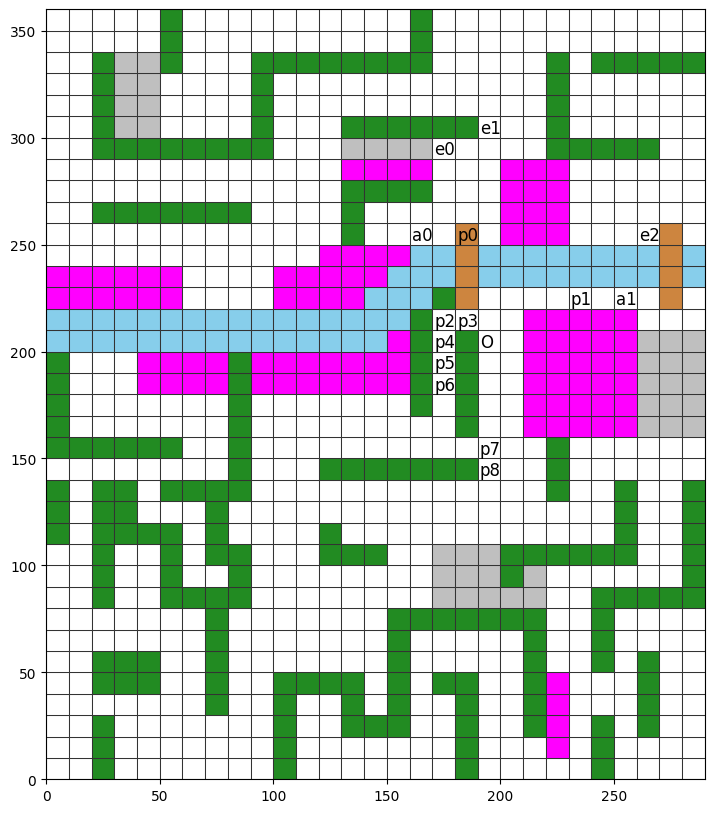

In [59]:
plot_cells_and_labels(get_map(), labels=outpt)

#### other testing

In [70]:
dfsel, outpt=select_cells(y_and_x=(20,14), 
                          enemy_y_and_x=[(6,17), (5,19), (13,9)], 
                          ally_y_and_x=[(10, 16), (18, 9)])
dfsel 

,y,x,shoot_e0,shoot_e1,shoot_e2,def,enemy_camp_prox,our_camp_prox,prox_e0,prox_e1,prox_e2,prox_a0,prox_a1
0,17,17,False,False,False,7,61,58,0.135439,0.056945,0,0,0.0
1,18,10,False,False,True,1,51,52,0.000000,0.000000,0,0,1.0
2,18,17,False,False,False,7,60,59,0.056945,0.000000,0,0,0.0
3,19,17,False,False,False,6,59,60,0.000000,0.000000,0,0,0.0
4,20,19,False,False,False,4,58,63,0.000000,0.000000,0,0,0.0
5,21,19,False,False,False,3,57,64,0.000000,0.000000,0,0,0.0


In [71]:
run_goap_on_selected_cells(dfsel)

,path,cost,attack_cost,defence_cost,length,action_0,action_1,action_2,action_3
0,"[goto_1, shoot_from_p1_at_e2, shoot_from_p1_at...",8.100000,4.2,1.800000,3,goto_1,shoot_from_p1_at_e2,shoot_from_p1_at_e2,None
1,[goto_2],6.581941,1.8,3.881941,1,goto_2,None,None,None
2,[goto_3],6.233333,1.6,3.833333,1,goto_3,None,None,None
3,[goto_0],6.038080,2.0,3.038080,1,goto_0,None,None,None
4,[goto_4],5.433333,1.4,3.333333,1,goto_4,None,None,None
5,"[goto_1, shoot_from_p1_at_e2]",5.050000,2.1,1.900000,2,goto_1,shoot_from_p1_at_e2,None,None
6,[goto_5],4.800000,1.2,3.000000,1,goto_5,None,None,None
7,[goto_1],2.000000,0.0,2.000000,1,goto_1,None,None,None


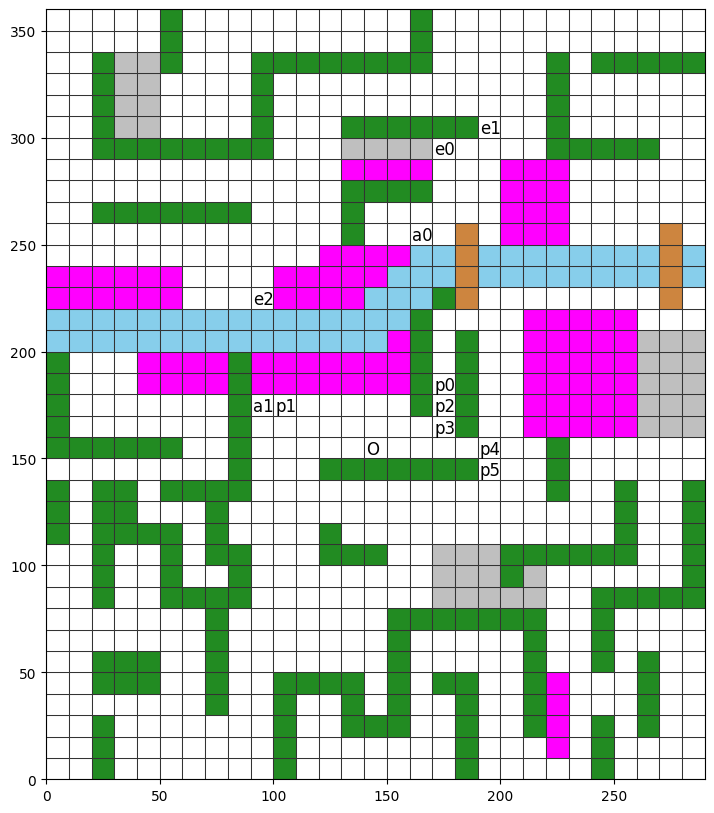

In [72]:
plot_cells_and_labels(get_map(), labels=outpt)

#### goap waste

In [12]:
cols_to_normalize=['def','enemy_camp_prox','our_camp_prox']
minvals=dfsel.min()
for col in cols_to_normalize:
    dfsel[col]-=minvals[col]
maxvals=dfsel.max()
for col in cols_to_normalize:
    dfsel[col]/=maxvals[col]
    
dfsel

,y,x,shoot_e0,shoot_e1,shoot_e2,def,enemy_camp_prox,our_camp_prox,prox_e0,prox_e1,prox_e2,prox_a0,prox_a1
0,10,18,True,True,False,0.142857,1.000000,0.000000,1.000000,0.887686,0.000000,1.000000,0.000000
1,13,23,False,False,True,0.000000,0.333333,0.166667,0.135439,0.056945,0.648378,0.000000,1.000000
2,14,17,False,False,False,0.428571,0.583333,0.250000,0.425764,0.322130,0.000000,0.256481,0.000000
3,14,18,False,False,False,0.285714,0.666667,0.333333,0.534743,0.425764,0.056945,0.425764,0.107837
4,15,17,False,False,False,0.857143,0.500000,0.333333,0.322130,0.224832,0.000000,0.107837,0.000000
5,16,17,False,False,False,1.000000,0.416667,0.416667,0.224832,0.135439,0.000000,0.000000,0.000000
6,17,17,False,False,False,1.000000,0.333333,0.500000,0.135439,0.056945,0.000000,0.000000,0.000000
7,20,19,False,False,False,0.571429,0.083333,0.916667,0.000000,0.000000,0.000000,0.000000,0.000000
8,21,19,False,False,False,0.428571,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [13]:
ally_defs=[2, 2]
enemy_atks=[5, 5, 5]

friend_coef=2
foe_coef=1

enemy_cost=[5, 6, 3]
attack_coef=2
prob_of_hit=0.35

prox_enlarge_coef=2
def_enlarge_coef=3

dfsel['positional_attack']=prox_enlarge_coef*dfsel.enemy_camp_prox
dfsel['positional_defence']=(prox_enlarge_coef*dfsel.our_camp_prox)+(def_enlarge_coef*dfsel['def'])

ally_prox_columns=dfsel[[s for s in dfsel.columns if s.split('_')[0]=='prox' and s.split('_')[1][0]=='a']].to_numpy()
dfsel['defence_from_allies']=(ally_prox_columns*ally_defs).sum(axis=1)

enemy_prox_columns=dfsel[[s for s in dfsel.columns if s.split('_')[0]=='prox' and s.split('_')[1][0]=='e']].to_numpy()
dfsel['defence_from_enemies']=(-1*enemy_prox_columns*enemy_atks).sum(axis=1)

dfsel['total_defence']=dfsel.positional_defence+dfsel.defence_from_allies+dfsel.defence_from_enemies

dfsel

,y,x,shoot_e0,shoot_e1,shoot_e2,def,enemy_camp_prox,our_camp_prox,prox_e0,prox_e1,prox_e2,prox_a0,prox_a1,positional_attack,positional_defence,defence_from_allies,defence_from_enemies,total_defence
0,10,18,True,True,False,0.142857,1.000000,0.000000,1.000000,0.887686,0.000000,1.000000,0.000000,2.000000,0.428571,2.000000,-9.438428,-7.009856
1,13,23,False,False,True,0.000000,0.333333,0.166667,0.135439,0.056945,0.648378,0.000000,1.000000,0.666667,0.333333,2.000000,-4.203812,-1.870479
2,14,17,False,False,False,0.428571,0.583333,0.250000,0.425764,0.322130,0.000000,0.256481,0.000000,1.166667,1.785714,0.512961,-3.739467,-1.440792
3,14,18,False,False,False,0.285714,0.666667,0.333333,0.534743,0.425764,0.056945,0.425764,0.107837,1.333333,1.523810,1.067201,-5.087258,-2.496248
4,15,17,False,False,False,0.857143,0.500000,0.333333,0.322130,0.224832,0.000000,0.107837,0.000000,1.000000,3.238095,0.215674,-2.734808,0.718961
5,16,17,False,False,False,1.000000,0.416667,0.416667,0.224832,0.135439,0.000000,0.000000,0.000000,0.833333,3.833333,0.000000,-1.801353,2.031980
6,17,17,False,False,False,1.000000,0.333333,0.500000,0.135439,0.056945,0.000000,0.000000,0.000000,0.666667,4.000000,0.000000,-0.961920,3.038080
7,20,19,False,False,False,0.571429,0.083333,0.916667,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,3.547619,0.000000,0.000000,3.547619
8,21,19,False,False,False,0.428571,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.285714,0.000000,0.000000,3.285714


In [14]:
n_positions=dfsel.shape[0]
moveshoot=dfsel[[s for s in dfsel.columns if s.split('_')[0]=='shoot']].to_numpy()
actionlist=[]
for i in range(n_positions):
    actionlist.append(Action(name='goto_'+str(i), 
                             cost=DoubleCost(defence_cost=dfsel.total_defence[i], attack_cost=dfsel.positional_attack[i]), 
                             pre_equals=WorldState({'Movement':False}), 
                             post_set=WorldState({'Movement':True, 'Position_'+str(i):True})))


for [position, target] in np.argwhere(moveshoot==1):
    actionlist.append(Action(name=f'shoot_from_p{position}_at_e{target}', 
                             cost=DoubleCost(defence_cost=-0.1, attack_cost=attack_coef*prob_of_hit*enemy_cost[target]), 
                             pre_equals=WorldState({f'Position_{position}':True}), 
                             post_inc=WorldState({'Shots':-1})))

In [15]:
for a in actionlist:
    print(str(a))

Action: goto_0, Cost: Defence value: -7.009856251775437, Attack value: 2.0
  Preconditions:  equals: {'Movement': False}, less: None, more: None
  Effects:  set: {'Movement': True, 'Position_0': True}, increment: None
Action: goto_1, Cost: Defence value: -1.8704787024896121, Attack value: 0.6666666666666666
  Preconditions:  equals: {'Movement': False}, less: None, more: None
  Effects:  set: {'Movement': True, 'Position_1': True}, increment: None
Action: goto_2, Cost: Defence value: -1.4407918724144086, Attack value: 1.1666666666666667
  Preconditions:  equals: {'Movement': False}, less: None, more: None
  Effects:  set: {'Movement': True, 'Position_2': True}, increment: None
Action: goto_3, Cost: Defence value: -2.49624768124266, Attack value: 1.3333333333333333
  Preconditions:  equals: {'Movement': False}, less: None, more: None
  Effects:  set: {'Movement': True, 'Position_3': True}, increment: None
Action: goto_4, Cost: Defence value: 0.7189608895251203, Attack value: 1.0
  Preco

In [16]:
constraint=Constraint(more=WorldState({'Shots':-1}))

goal=Goal(equals=WorldState({'Movement':True}))

dicti={'Movement':False, 'Shots':2}
for i in range(n_positions):
    dicti[f'Position_{i}']=False
ws=WorldState(dicti)


In [17]:
print(ws)

{'Movement': False, 'Shots': 2, 'Position_0': False, 'Position_1': False, 'Position_2': False, 'Position_3': False, 'Position_4': False, 'Position_5': False, 'Position_6': False, 'Position_7': False, 'Position_8': False}


In [21]:
df_planner=Planner_df(actions=actionlist, 
                      worldstate=WorldState(dicti), 
                      goal=goal, 
                      constraint=constraint, 
                      max_depth=4)
df_plans=df_planner.plan()

df_plans

,path,cost,attack_cost,defence_cost,length,action_0,action_1,action_2,action_3
0,[goto_6],3.738080,0.666667,3.038080,1,goto_6,None,None,None
1,[goto_7],3.722619,0.166667,3.547619,1,goto_7,None,None,None
2,"[goto_0, shoot_from_p0_at_e1, shoot_from_p0_at...",3.710144,10.400000,-7.209856,3,goto_0,shoot_from_p0_at_e1,shoot_from_p0_at_e1,None
3,[goto_8],3.285714,0.000000,3.285714,1,goto_8,None,None,None
4,"[goto_1, shoot_from_p1_at_e2, shoot_from_p1_at...",3.039521,4.866667,-2.070479,3,goto_1,shoot_from_p1_at_e2,shoot_from_p1_at_e2,None
5,"[goto_0, shoot_from_p0_at_e0, shoot_from_p0_at...",2.975144,9.700000,-7.209856,3,goto_0,shoot_from_p0_at_e0,shoot_from_p0_at_e1,None
6,"[goto_0, shoot_from_p0_at_e1, shoot_from_p0_at...",2.975144,9.700000,-7.209856,3,goto_0,shoot_from_p0_at_e1,shoot_from_p0_at_e0,None
7,[goto_5],2.906980,0.833333,2.031980,1,goto_5,None,None,None
8,"[goto_0, shoot_from_p0_at_e0, shoot_from_p0_at...",2.240144,9.000000,-7.209856,3,goto_0,shoot_from_p0_at_e0,shoot_from_p0_at_e0,None
9,[goto_4],1.768961,1.000000,0.718961,1,goto_4,None,None,None


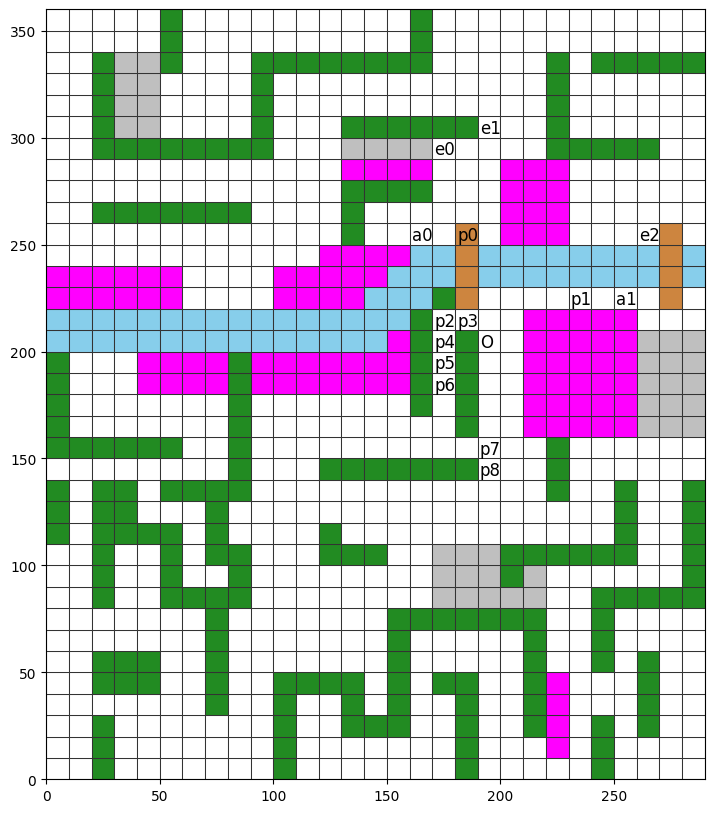

In [19]:
plot_cells_and_labels(get_map(), labels=outpt)

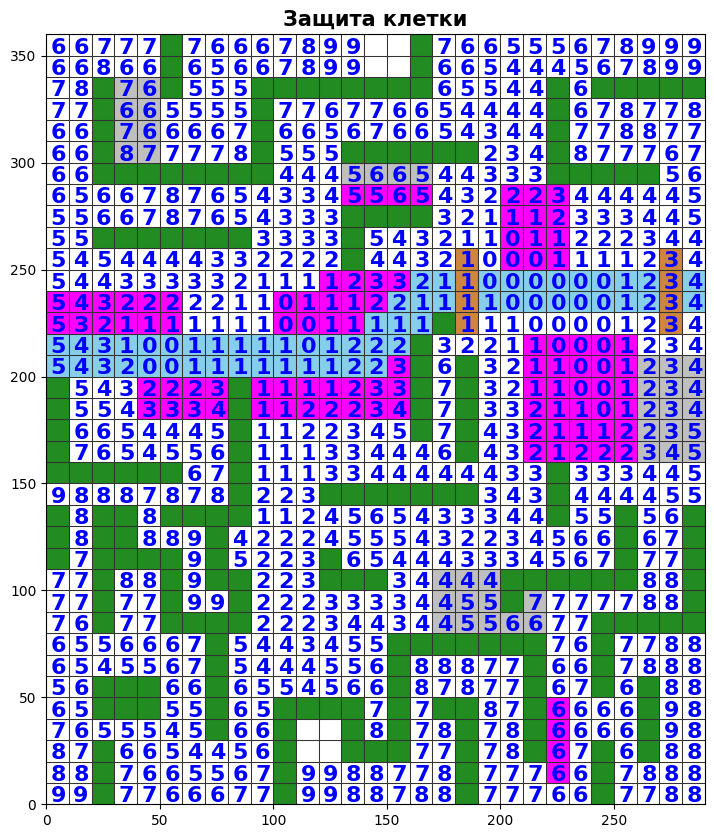

In [10]:
plot_cell_defence_vals()

In [ ]:


move_shoot=np.array([[0,0,0,0,1],
                     [0,0,0,0,1],
                     [0,0,0,1,0]])

df_planner=Planner_df(actions=get_actionlist(move_shoot), 
                      worldstate=get_worldstate(move_shoot.shape[1]), 
                      goal=goal, 
                      constraint=constraint, 
                      max_depth=4)
df_plans=df_planner.plan()

df_plans

In [19]:
ally_defs=[2, 2]
enemy_atks=[5, 5, 5]

friend_coef=2
foe_coef=1

def get_pos_cost(num):
    positional_attack=[0,0.1,1,5,2]
    positional_defence=[3,4,6,2,1]
    b1_proximity=[0,0,0.5,0.5,1]
    b2_proximity=[0,0,0,1,0.5]
    z1_proximity=[0,0,0,0.5,1]
    z2_proximity=[0,0,0,0.5,1]
    z3_proximity=[0,0,0,1,0.5]
    i=num-1
    attack=positional_attack[i]
    friend_score=def_b1*b1_proximity[i]+def_b2*b2_proximity[i]
    foe_score=(-1)*(atk_z1*z1_proximity[i]+atk_z2*z2_proximity[i]+atk_z3*z3_proximity[i])
    defence=positional_defence[i]+friend_coef*friend_score+foe_coef*foe_score
    return DoubleCost(defence_cost=defence, attack_cost=attack)



n_positions=dfsel.shape[0]
moveshoot=dfsel[[s for s in dfsel.columns if s.split('_')[0]=='shoot']].to_numpy()
actionlist=[]
for i in range(n_positions):
    actionlist.append(Action(name='goto_'+str(i), 
                             cost=DoubleCost(defence_cost=0, attack_cost=0), 
                             pre_equals=WorldState({'Movement':False}), 
                             post_set=WorldState({'Movement':True, 'Position_'+str(i):True})))

attack_coef=3
prob_of_hit=0.35
for [position, target] in np.argwhere(moveshoot==1):
    actionlist.append(Action(name=f'shoot_from_p{position}_at_e{target}', 
                             cost=DoubleCost(defence_cost=-0.1, attack_cost=attack_coef*prob_of_hit*enemy_cost[target]), 
                             pre_equals=WorldState({f'Position_{position}':True}), 
                             post_inc=WorldState({'Shots':-1})))

In [ ]:
## move params
friend_coef=2
foe_coef=1

def_b1=2
def_b2=2
atk_z1=5
atk_z2=5
atk_z3=5

def get_pos_cost(num):
    positional_attack=[0,0.1,1,5,2]
    positional_defence=[3,4,6,2,1]
    b1_proximity=[0,0,0.5,0.5,1]
    b2_proximity=[0,0,0,1,0.5]
    z1_proximity=[0,0,0,0.5,1]
    z2_proximity=[0,0,0,0.5,1]
    z3_proximity=[0,0,0,1,0.5]
    i=num-1
    attack=positional_attack[i]
    friend_score=def_b1*b1_proximity[i]+def_b2*b2_proximity[i]
    foe_score=(-1)*(atk_z1*z1_proximity[i]+atk_z2*z2_proximity[i]+atk_z3*z3_proximity[i])
    defence=positional_defence[i]+friend_coef*friend_score+foe_coef*foe_score
    return DoubleCost(defence_cost=defence, attack_cost=attack)

## shoot params
enemy_cost=[5, 6, 3]
attack_coef=3
prob_of_hit=0.35

In [170]:
def get_worldstate(n_positions):
    dicti={'Movement':False, 'Shots':2}
    for i in range(n_positions):
        dicti[f'Position_{i+1}']=False
    return WorldState(dicti)

def get_actionlist_no_cost(moveshoot, enemy_cost):
    n_positions=moveshoot.shape[0]
    #n_targets=moveshoot.shape[0]
    actionlist=[]
    for i in range(n_positions):
        actionlist.append(Action(name='goto_'+str(i), 
                                 cost=DoubleCost(defence_cost=0, attack_cost=0), 
                                 pre_equals=WorldState({'Movement':False}), 
                                 post_set=WorldState({'Movement':True, 'Position_'+str(i):True})))
    
    attack_coef=3
    prob_of_hit=0.35
    for [position, target] in np.argwhere(moveshoot==1):
        actionlist.append(Action(name=f'shoot_from_p{position}_at_e{target}', 
                                 cost=DoubleCost(defence_cost=-0.1, attack_cost=attack_coef*prob_of_hit*enemy_cost[target]), 
                                 pre_equals=WorldState({f'Position_{position}':True}), 
                                 post_inc=WorldState({'Shots':-1})))
    return actionlist

In [ ]:


friend_coef=2
foe_coef=1

def get_pos_cost(num):
    positional_attack=[0,0.1,1,5,2]
    positional_defence=[3,4,6,2,1]
    b1_proximity=[0,0,0.5,0.5,1]
    b2_proximity=[0,0,0,1,0.5]
    z1_proximity=[0,0,0,0.5,1]
    z2_proximity=[0,0,0,0.5,1]
    z3_proximity=[0,0,0,1,0.5]
    i=num-1
    attack=positional_attack[i]
    friend_score=def_b1*b1_proximity[i]+def_b2*b2_proximity[i]
    foe_score=(-1)*(atk_z1*z1_proximity[i]+atk_z2*z2_proximity[i]+atk_z3*z3_proximity[i])
    defence=positional_defence[i]+friend_coef*friend_score+foe_coef*foe_score
    return DoubleCost(defence_cost=defence, attack_cost=attack)

In [164]:
moveshoot=dfsel[[s for s in dfsel.columns if s.split('_')[0]=='shoot']].to_numpy()
moveshoot

array([[ True,  True, False],
       [False, False,  True],
       [False, False, False],
       [False, False, False],
       [False, False, False],
       [False, False, False],
       [False, False, False],
       [False, False, False],
       [False, False, False],
       [False, False, False]])

In [171]:
actlist=get_actionlist_no_cost(moveshoot, enemy_cost=[5, 6, 3])
for a in actlist:
    print(str(a))

Action: goto_0, Cost: Defence value: 0.0, Attack value: 0.0
  Preconditions:  equals: {'Movement': False}, less: None, more: None
  Effects:  set: {'Movement': True, 'Position_0': True}, increment: None
Action: goto_1, Cost: Defence value: 0.0, Attack value: 0.0
  Preconditions:  equals: {'Movement': False}, less: None, more: None
  Effects:  set: {'Movement': True, 'Position_1': True}, increment: None
Action: goto_2, Cost: Defence value: 0.0, Attack value: 0.0
  Preconditions:  equals: {'Movement': False}, less: None, more: None
  Effects:  set: {'Movement': True, 'Position_2': True}, increment: None
Action: goto_3, Cost: Defence value: 0.0, Attack value: 0.0
  Preconditions:  equals: {'Movement': False}, less: None, more: None
  Effects:  set: {'Movement': True, 'Position_3': True}, increment: None
Action: goto_4, Cost: Defence value: 0.0, Attack value: 0.0
  Preconditions:  equals: {'Movement': False}, less: None, more: None
  Effects:  set: {'Movement': True, 'Position_4': True}, i

In [163]:
np.argwhere(shoot_df==True)

array([[0, 0],
       [0, 1],
       [1, 2]], dtype=int64)

In [158]:
wrld_state=get_worldstate(dfsel.shape[0])
wrld_state.get_state()

{'Movement': False,
 'Shots': 2,
 'Position_1': False,
 'Position_2': False,
 'Position_3': False,
 'Position_4': False,
 'Position_5': False,
 'Position_6': False,
 'Position_7': False,
 'Position_8': False,
 'Position_9': False,
 'Position_10': False}

In [ ]:
move_shoot=np.array([[0,0,0,0,1],
                    [0,0,0,0,1],
                    [0,0,0,1,0]])



#### integrating

In [144]:
dfsel, outpt=select_cells(y_and_x=(15,19), 
                          enemy_y_and_x=[(6,17), (5,19), (10,26)], 
                          ally_y_and_x=[(10, 16), (13, 25)])
dfsel                   

,y,x,shoot_e0,shoot_e1,shoot_e2,def,enemy_camp_prox,our_camp_prox,prox_e0,prox_e1,prox_e2,prox_a0,prox_a1
0,10,18,True,True,False,1,69,52,1.000000,0.887686,0.000000,1.000000,0.000000
1,13,23,False,False,True,0,61,54,0.135439,0.056945,0.648378,0.000000,1.000000
2,14,17,False,False,False,3,64,55,0.425764,0.322130,0.000000,0.256481,0.000000
3,14,18,False,False,False,2,65,56,0.534743,0.425764,0.056945,0.425764,0.107837
4,15,17,False,False,False,4,63,56,0.322130,0.224832,0.000000,0.107837,0.000000
5,16,17,False,False,False,5,62,57,0.224832,0.135439,0.000000,0.000000,0.000000
6,17,17,False,False,False,6,61,58,0.135439,0.056945,0.000000,0.000000,0.000000
7,20,18,False,False,False,5,57,62,0.000000,0.000000,0.000000,0.000000,0.000000
8,20,19,False,False,False,4,58,63,0.000000,0.000000,0.000000,0.000000,0.000000
9,21,19,False,False,False,3,57,64,0.000000,0.000000,0.000000,0.000000,0.000000


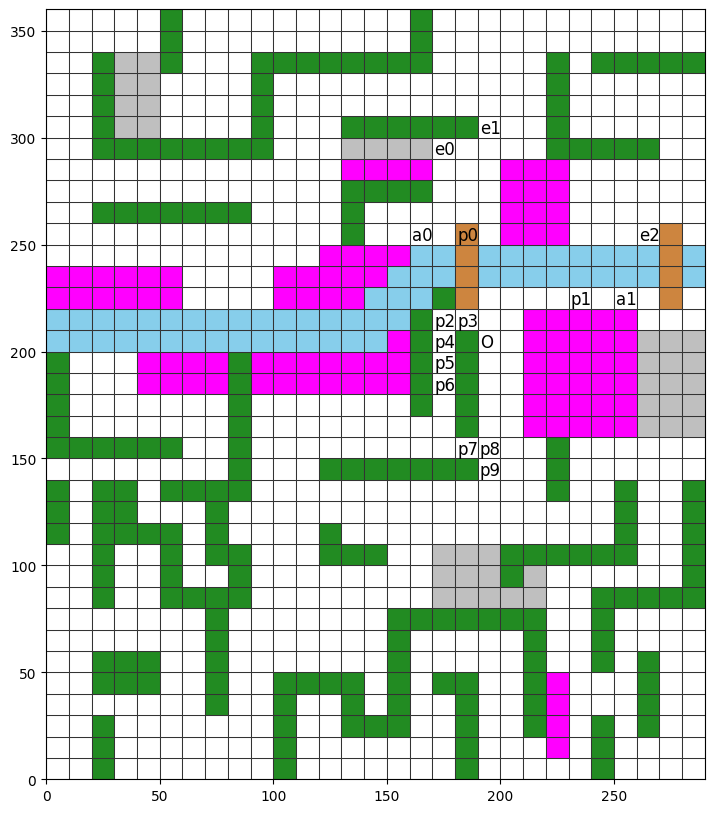

In [145]:
plot_cells_and_labels(get_map(), outpt)

In [146]:
dfsel, outpt=select_cells(y_and_x=(23,15), 
                          enemy_y_and_x=[(19,9), (27, 9), (10,26)], 
                          ally_y_and_x=[(20, 16), (23, 22)])
dfsel  

,y,x,shoot_e0,shoot_e1,shoot_e2,def,enemy_camp_prox,our_camp_prox,prox_e0,prox_e1,prox_e2,prox_a0,prox_a1
0,21,11,True,False,False,3,51,56,1.000000,0.648378,0,0.425764,0.000000
1,21,19,False,False,False,3,57,64,0.224832,0.000000,0,0.806268,0.610017
2,22,12,True,False,False,4,49,58,0.887686,0.648378,0,0.107837,0.000000
3,22,14,False,False,False,6,51,60,0.648378,0.425764,0,0.000000,0.000000
4,22,15,False,False,False,5,52,61,0.534743,0.322130,0,0.000000,0.107837
5,22,20,False,False,False,4,55,64,0.056945,0.000000,0,0.425764,1.000000
6,23,11,True,True,False,2,49,58,0.887686,0.887686,0,0.107837,0.000000
7,24,11,False,True,False,3,48,59,0.766158,1.000000,0,0.000000,0.000000
8,24,13,False,False,False,6,48,61,0.534743,0.534743,0,0.000000,0.000000
9,27,14,False,True,False,4,46,65,0.135439,1.000000,0,0.000000,0.000000


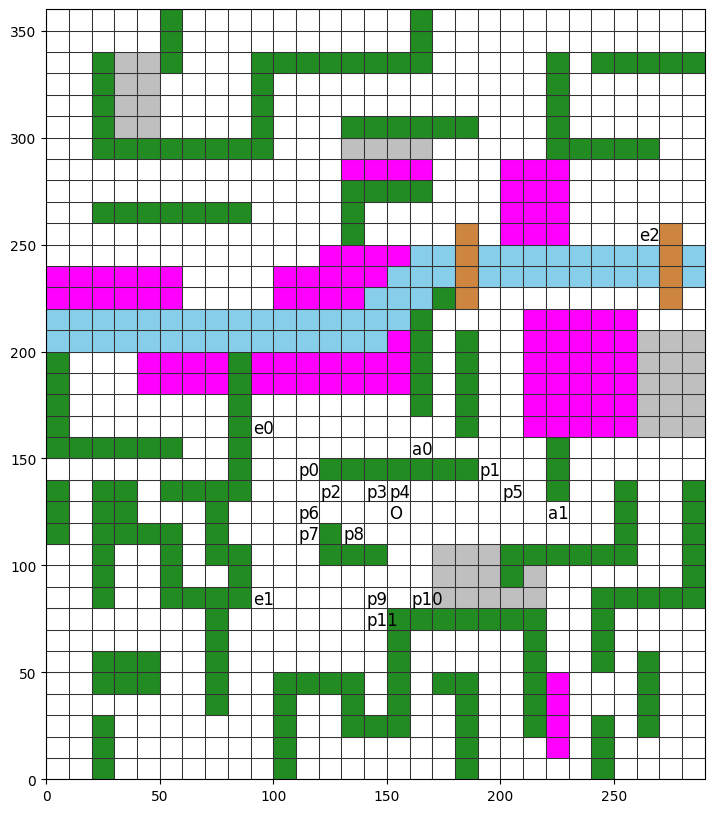

In [147]:
plot_cells_and_labels(get_map(), outpt)

In [167]:
reachable_cells=np.where(reachable_cells_labels(y_and_x=y_and_x)!='')
reachable_cells=np.array([reachable_cells[0],reachable_cells[1]]).T

defence_values=[]
all_def_vals=get_cell_defence_vals()
enemy_camp_proximity_values=[]
all_enemy_camp_proximity_values=get_enemy_camp_proximity_vals()
our_camp_proximity_vals=[]
all_our_camp_proximity_vals=get_our_camp_proximity_vals()

for [y, x] in reachable_cells:
    defence_values.append(all_def_vals[y,x])
    enemy_camp_proximity_values.append(all_enemy_camp_proximity_values[y,x])
    our_camp_proximity_vals.append(all_our_camp_proximity_vals[y,x])
    
##selecting by proximity to opponent camp
df_selection=pd.DataFrame(reachable_cells)
df_selection.columns=['y','x']
df_selection['def']=defence_values
df_selection['atk']=enemy_camp_proximity_values
df_selection.drop_duplicates(subset=['def', 'atk'], inplace=True)
selected_cells_prox_opp=select_from_df(df_selection)[:,:2]

##selecting by proximity to our camp
df_selection=pd.DataFrame(reachable_cells)
df_selection.columns=['y','x']
df_selection['def']=defence_values
df_selection['atk']=our_camp_proximity_vals
df_selection.drop_duplicates(subset=['def', 'atk'], inplace=True)
selected_cells_prox_our=select_from_df(df_selection)[:,:2]

In [168]:
selected_cells_prox_opp

array([[10, 18],
       [14, 17],
       [14, 18],
       [15, 17],
       [16, 17],
       [17, 17]], dtype=int64)

In [169]:
selected_cells_prox_our

array([[17, 17],
       [20, 18],
       [20, 19],
       [21, 19]], dtype=int64)

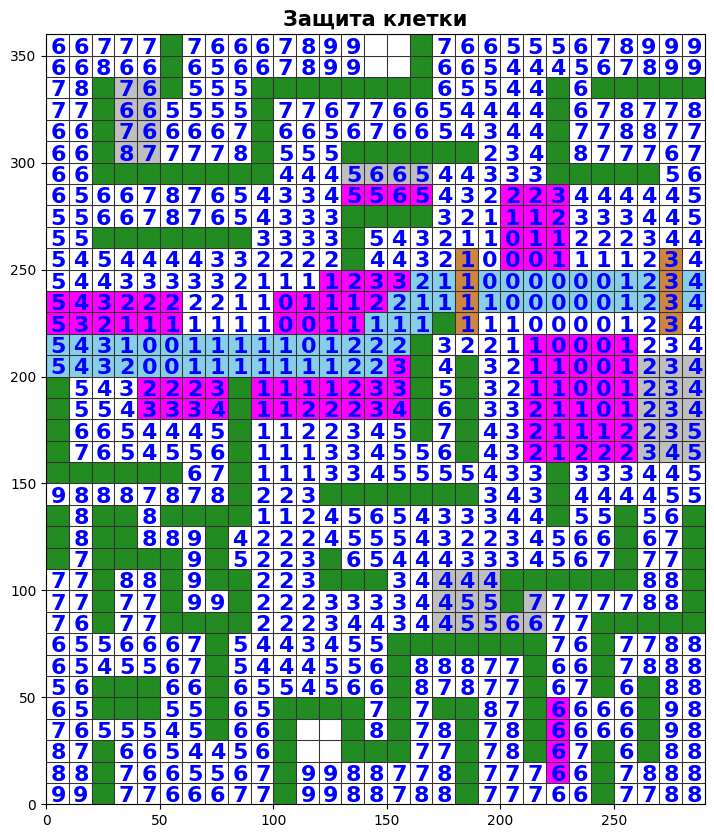

In [176]:
plot_cell_defence_vals()

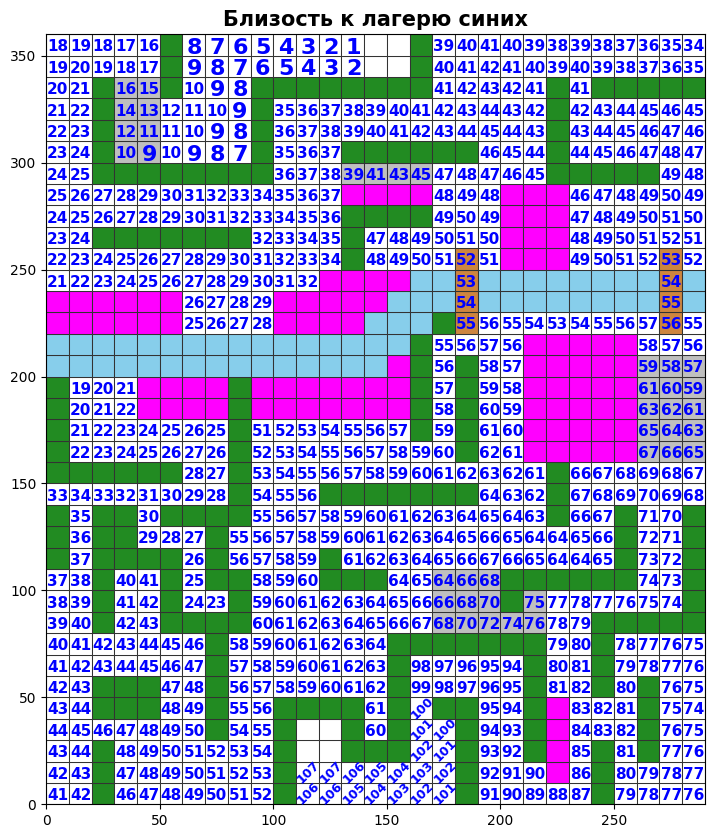

In [173]:
plot_our_camp_proximity_vals(cells=get_map(), our_camp_proximity_vals=get_our_camp_proximity_vals())

In [174]:
##selecting by proximity to our camp
df_selection=pd.DataFrame(reachable_cells)
df_selection.columns=['y','x']
df_selection['def']=defence_values
df_selection['atk']=our_camp_proximity_vals
df_selection.drop_duplicates(subset=['def', 'atk'], inplace=True)
selected_cells_prox_our=select_from_df(df_selection)[:,:2]
selected_cells_prox_our

array([[17, 17],
       [20, 18],
       [20, 19],
       [21, 19]], dtype=int64)

In [175]:
select_from_df(df_selection)

array([[17, 17,  6, 58],
       [20, 18,  5, 62],
       [20, 19,  4, 63],
       [21, 19,  3, 64]], dtype=int64)

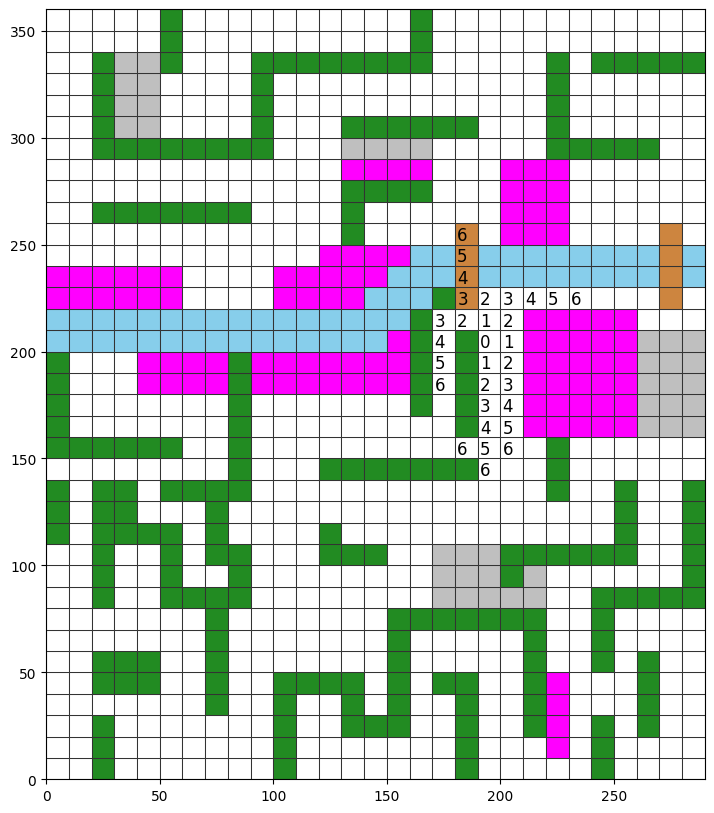

In [171]:
plot_cells_and_labels(get_map(), reachable_cells_labels(y_and_x=y_and_x))

In [170]:
np.unique(np.append(selected_cells_prox_opp,selected_cells_prox_our,axis=0), axis=0)

array([[10, 18],
       [14, 17],
       [14, 18],
       [15, 17],
       [16, 17],
       [17, 17],
       [20, 18],
       [20, 19],
       [21, 19]], dtype=int64)

In [166]:
a=np.array([[1,2], [1,3], [1,4], [1,5]])
b=np.array([[1,2], [1,7], [1,8], [1,5]])
np.unique(np.append(a,b,axis=0), axis=0)

array([[1, 2],
       [1, 3],
       [1, 4],
       [1, 5],
       [1, 7],
       [1, 8]])

In [161]:
#reachable_cells=np.where(split_cells_by_half(reachable_cells_labels(y_and_x=y_and_x), half=2, y_and_x=y_and_x)!='')
reachable_cells=np.where(reachable_cells_labels(y_and_x=y_and_x)!='')
reachable_cells=np.array([reachable_cells[0],reachable_cells[1]]).T
df_selection=pd.DataFrame(reachable_cells)
df_selection.columns=['y','x']

defence_values=[]
all_def_vals=get_cell_defence_vals()
attack_values=[]
all_atk_vals=get_enemy_camp_proximity_vals()

for [y, x] in reachable_cells:
    defence_values.append(all_def_vals[y,x])
    attack_values.append(all_atk_vals[y,x])
    
df_selection['def']=defence_values
df_selection['atk']=attack_values
df_selection.drop_duplicates(subset=['def', 'atk'], inplace=True)
df_selection

,y,x,def,atk
0,10,18,1,69
1,11,18,1,68
2,12,18,1,67
3,13,18,1,66
4,13,19,1,65
5,13,20,1,64
6,13,21,0,63
7,13,22,0,62
8,13,23,0,61
9,14,17,3,64


In [164]:
select_from_df(df_selection)[:,:2]

array([[10, 18],
       [14, 17],
       [14, 18],
       [15, 17],
       [16, 17],
       [17, 17]], dtype=int64)

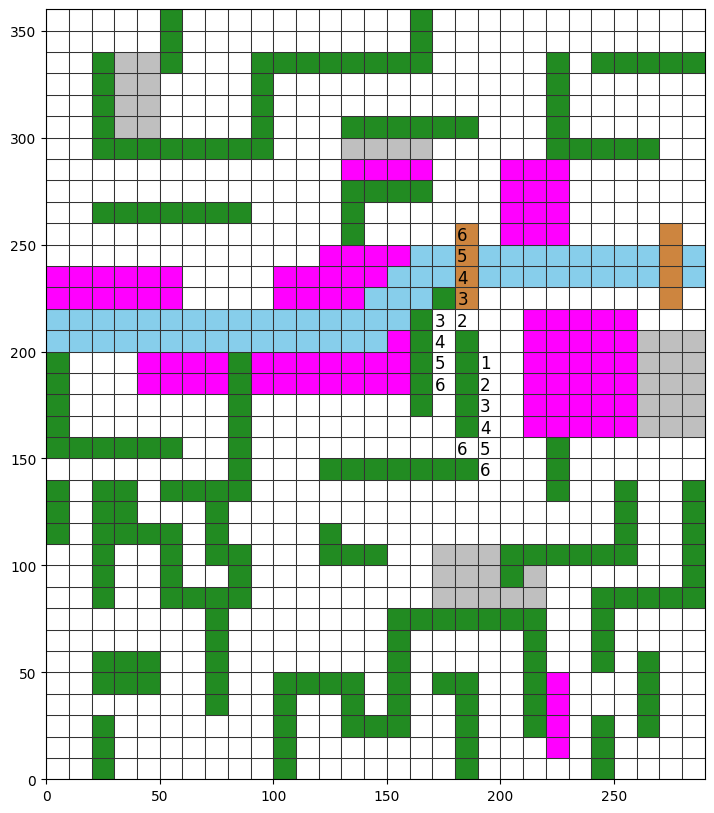

In [158]:
y_and_x=(15,19)
plot_cells_and_labels(get_map(), split_cells_by_half(reachable_cells_labels(y_and_x=y_and_x), half=2, y_and_x=y_and_x))

In [149]:
np.random.seed(seed=int(time.time()))
vals=pd.DataFrame(np.array([(100*np.random.uniform(size=(15))).astype(int),
                            (100*np.random.uniform(size=(15))).astype(int), 
                            (40+(10*np.random.uniform(size=(15)))).astype(int),
                            ((1000*np.random.uniform(size=(15))).astype(int)%10)]).T)
vals.columns=['x','y','atk','def']
vals.sort_values(by=['def','atk'],ascending=False)

,x,y,atk,def
10,48,15,43,9
5,52,18,41,8
4,39,73,46,7
9,77,71,46,7
8,62,71,44,7
12,95,95,41,7
6,67,2,48,6
3,37,80,43,5
1,29,52,47,4
7,70,58,43,3


In [150]:
vals

,x,y,atk,def
0,84,68,46,1
1,29,52,47,4
2,70,18,40,1
3,37,80,43,5
4,39,73,46,7
5,52,18,41,8
6,67,2,48,6
7,70,58,43,3
8,62,71,44,7
9,77,71,46,7


In [151]:
select_from_df(vals)

array([[39, 73, 46,  7],
       [67,  2, 48,  6],
       [48, 15, 43,  9],
       [44, 37, 49,  0]])

In [110]:
df_selection.iloc[5]

y      14
x      19
def     2
atk    64
Name: 5, dtype: int64

In [115]:
', '.join([str(el) for el in df_selection.iloc[5]])

'14, 19, 2, 64'

In [119]:
select_from_df(vals)

looking at: [50, 11, 45, 4]
looking at: [95, 22, 45, 0]
looking at: [60, 27, 43, 9]
looking at: [84, 41, 44, 2]


array([[53, 45, 47,  8]])

In [87]:
reachable_cells=np.where(split_cells_by_half(reachable_cells_labels(), half=1)!='')
reachable_cells=np.array([reachable_cells[0],reachable_cells[1]]).T
df_selection=pd.DataFrame(reachable_cells)
df_selection.columns=['y','x']

defence_values=[]
all_def_vals=get_cell_defence_vals()
attack_values=[]
all_atk_vals=get_enemy_camp_proximity_vals()

for [y, x] in reachable_cells:
    defence_values.append(all_def_vals[y,x])
    attack_values.append(all_atk_vals[y,x])
    
df_selection['def']=defence_values
df_selection['atk']=attack_values
df_selection.drop_duplicates(subset=['def', 'atk'], inplace=True)
df_selection

,y,x,def,atk
0,13,19,1,65
1,13,20,1,64
2,13,21,0,63
3,13,22,0,62
4,13,23,0,61
5,14,19,2,64
6,14,20,1,63
7,15,20,2,62
8,16,20,2,61
9,17,20,3,60


In [88]:
select_from_df(df_selection)

array([[13, 19,  1, 65],
       [14, 19,  2, 64],
       [17, 20,  3, 60]], dtype=int64)

In [80]:
upper_iter

12

In [39]:
reachable_cells=np.where(split_cells_by_half(reachable_cells_labels(), half=1)!='')
reachable_cells=np.array([reachable_cells[0],reachable_cells[1]]).T
df_selection=pd.DataFrame(reachable_cells)
df_selection.columns=['y','x']

defence_values=[]
all_def_vals=get_cell_defence_vals()
attack_values=[]
all_atk_vals=get_enemy_camp_proximity_vals()

for [y, x] in reachable_cells:
    defence_values.append(all_def_vals[y,x])
    attack_values.append(all_atk_vals[y,x])
    
df_selection['def']=defence_values
df_selection['atk']=attack_values

df_sel_copy=df_selection.copy()
df_selection=df_selection.loc[df_selection.groupby(by='def').atk.idxmax()]
df_selection=df_selection.loc[df_selection.groupby(by='atk')['def'].idxmax()]

df_selection1=df_selection.copy()
df_selection=df_sel_copy.copy()

df_selection=df_selection.loc[df_selection.groupby(by='atk')['def'].idxmax()]
df_selection=df_selection.loc[df_selection.groupby(by='def').atk.idxmax()]
print(df_selection)
df_selection1

    y   x  def  atk
0  13  19    1   65
5  14  19    2   64
9  17  20    3   60


,y,x,def,atk
9,17,20,3,60
2,13,21,0,63
5,14,19,2,64
0,13,19,1,65


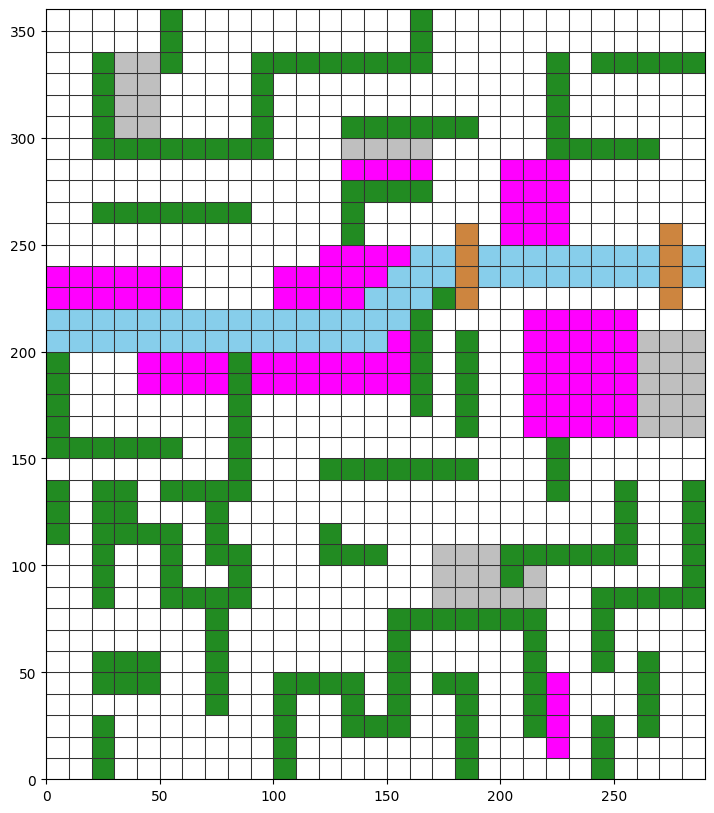

In [29]:
plot_cells_and_labels(get_map(), split_cells_by_half(reachable_cells_labels(y_and_x=(35,0)), half=2, y_and_x=(35,0)))

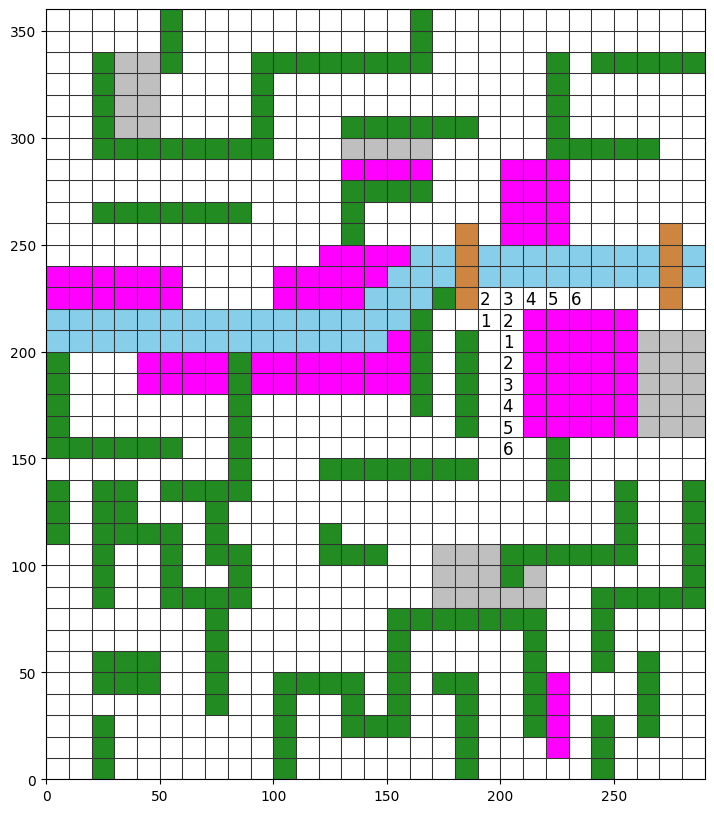

In [18]:
plot_cells_and_labels(get_map(), split_cells_by_half(reachable_cells_labels(), half=1))

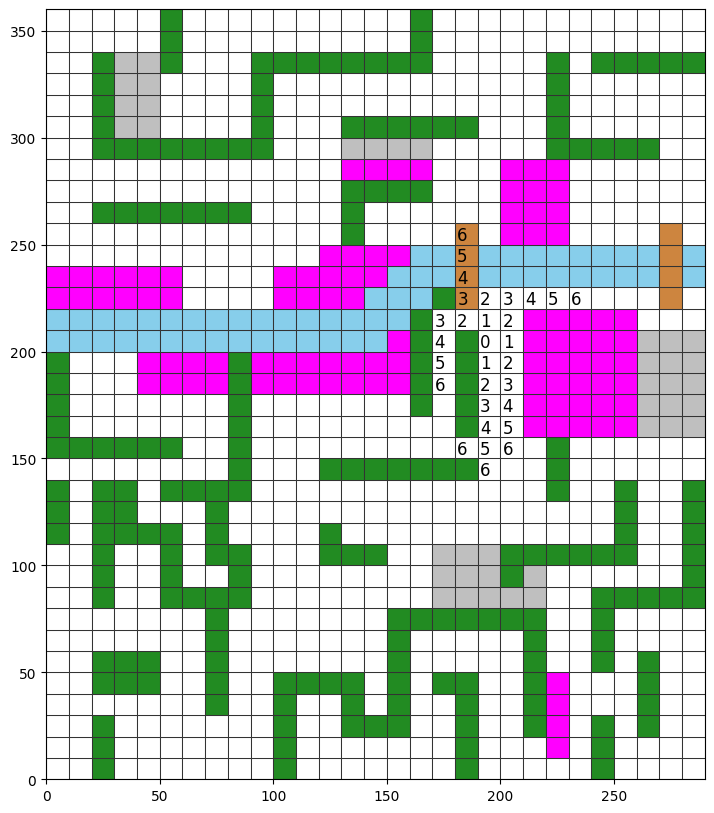

In [16]:
plot_cells_and_labels(get_map(), reachable_cells_labels())

In [90]:
df_selection

,y,x,def,atk
0,13,19,1,65
1,13,20,1,64
2,13,21,0,63
3,13,22,0,62
4,13,23,0,61
5,14,19,2,64
6,14,20,1,63


In [89]:
reachable_cells=np.where(split_cells_by_quarter(reachable_cells_labels(),y_and_x=(15,19), quarter=1)!='')
reachable_cells=np.array([reachable_cells[0],reachable_cells[1]]).T
df_selection=pd.DataFrame(reachable_cells)
df_selection.columns=['y','x']

defence_values=[]
all_def_vals=get_cell_defence_vals()
attack_values=[]
all_atk_vals=get_enemy_camp_proximity_vals()

for [y, x] in reachable_cells:
    defence_values.append(all_def_vals[y,x])
    attack_values.append(all_atk_vals[y,x])
    
df_selection['def']=defence_values
df_selection['atk']=attack_values
select_from_df(df_selection)

array([[13, 19,  1, 65],
       [14, 19,  2, 64]], dtype=int64)

In [5]:
reachable_cells=np.where(split_cells_by_quarter(reachable_cells_labels(),y_and_x=(15,19), quarter=1)!='')
reachable_cells=np.array([reachable_cells[0],reachable_cells[1]]).T
df_selection=pd.DataFrame(reachable_cells)
df_selection.columns=['y','x']

defence_values=[]
all_def_vals=get_cell_defence_vals()
attack_values=[]
all_atk_vals=get_enemy_camp_proximity_vals()

for [y, x] in reachable_cells:
    defence_values.append(all_def_vals[y,x])
    attack_values.append(all_atk_vals[y,x])
    
df_selection['def']=defence_values
df_selection['atk']=attack_values

df_sel_copy=df_selection.copy()
df_selection=df_selection.loc[df_selection.groupby(by='def').atk.idxmax()]
df_selection=df_selection.loc[df_selection.groupby(by='atk')['def'].idxmax()]

df_selection1=df_selection.copy()
df_selection=df_sel_copy.copy()

df_selection=df_selection.loc[df_selection.groupby(by='atk')['def'].idxmax()]
df_selection=df_selection.loc[df_selection.groupby(by='def').atk.idxmax()]
df_selection

,y,x,def,atk
3,13,22,0,62
0,13,19,1,65
5,14,19,2,64


In [6]:
df_selection1

,y,x,def,atk
2,13,21,0,63
5,14,19,2,64
0,13,19,1,65


In [7]:
dfsellll=pd.concat([df_selection, df_selection1]).drop_duplicates()
dfsellll

,y,x,def,atk
3,13,22,0,62
0,13,19,1,65
5,14,19,2,64
2,13,21,0,63


In [8]:
dfsellll=dfsellll.loc[dfsellll.groupby(by='def').atk.idxmax()]
dfsellll=dfsellll.loc[dfsellll.groupby(by='atk')['def'].idxmax()]
#dfsellll=dfsellll.loc[dfsellll.groupby(by='def').atk.idxmax()]
dfsellll

,y,x,def,atk
2,13,21,0,63
5,14,19,2,64
0,13,19,1,65


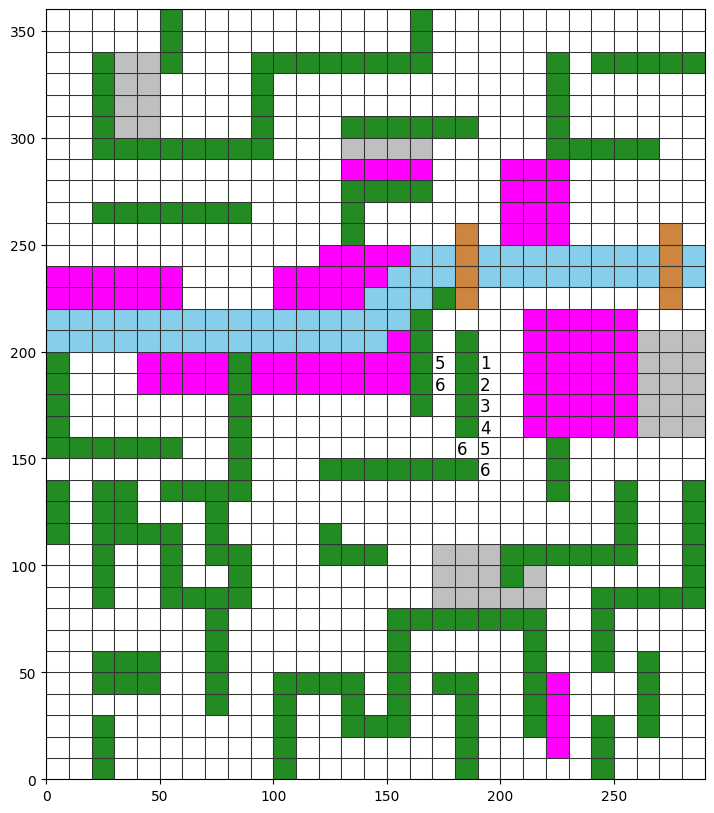

In [221]:
plot_cells_and_labels(get_map(), split_cells_by_quarter(reachable_cells_labels(),y_and_x=(15,19), quarter=3))

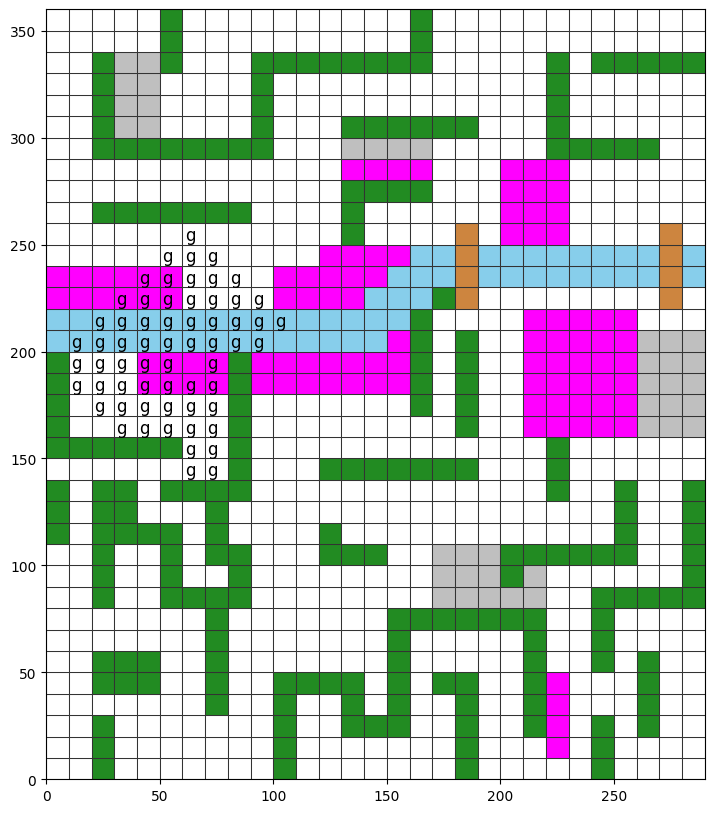

In [129]:
plot_cells_and_labels(get_map(), shooting_zone(enemy_y_and_x=(16,6)))

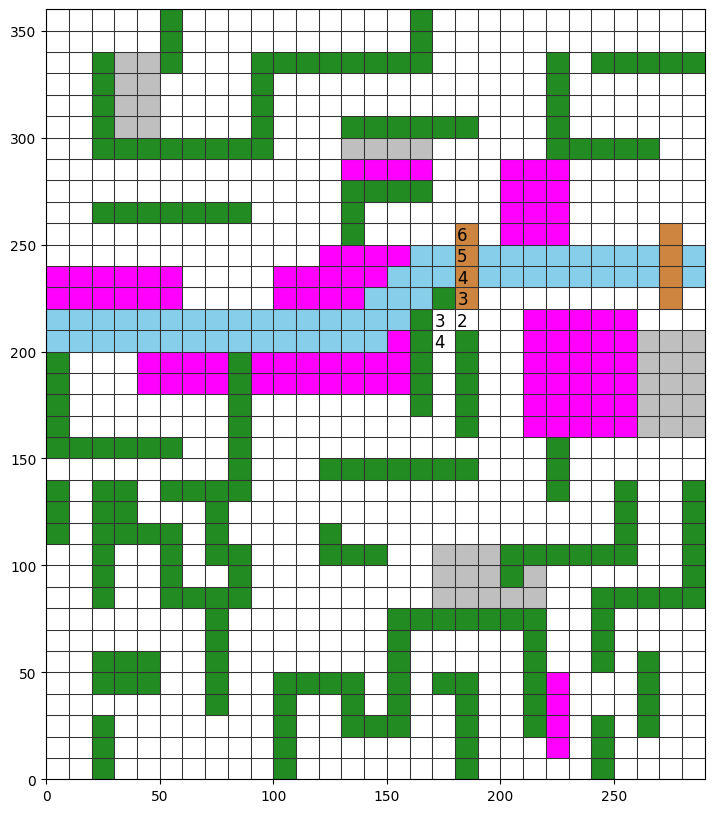

In [98]:
plot_cells_and_labels(get_map(), split_cells_by_quarter(reachable_cells_labels(),y_and_x=(15,19), quarter=4))

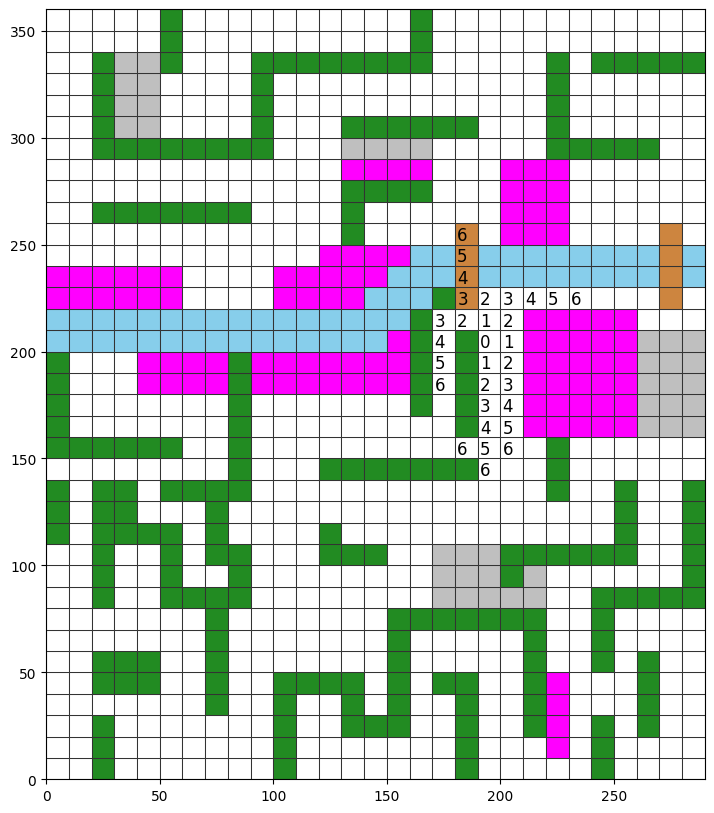

In [97]:
plot_cells_and_labels(get_map(), reachable_cells_labels())

#### map

In [5]:
cells=get_map()

In [6]:
b_position=[15, 19]
b_steps=[[21, 19],[20, 18],[17, 17],[13, 23],[10, 18]]

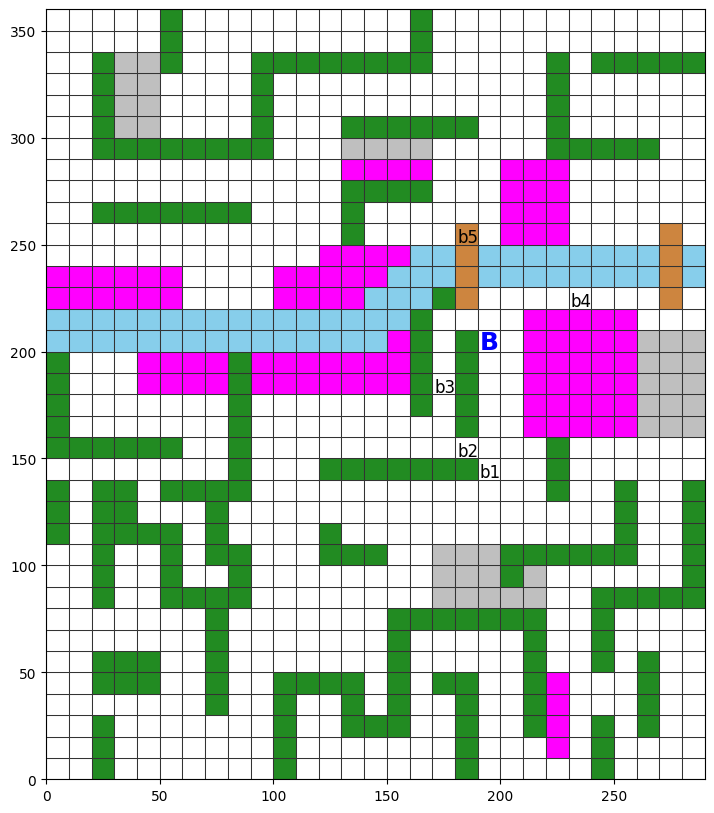

In [7]:
fig, ax= plt.subplots(figsize=(8.5,10))
ax.set_xlim(left=0, right=290)
ax.set_ylim(bottom=0, top=360)
for i in range(36):
    for j in range(29):
        rect=Rectangle((10*j, 10*i), 10, 10, linewidth=0.75, edgecolor='0.2', facecolor=get_color(cells[36-i-1][j]))
        ax.add_patch(rect)

ax.text(10*b_position[1] + 1,10*(36-b_position[0]-1) + 1,'B',size=18, color='blue', weight='semibold')
for i in range(len(b_steps)):
    ax.text(10*b_steps[i][1] + 1,10*(36-b_steps[i][0]-1) + 1,'b'+str(i+1),size=12)
# rect=Rectangle((20, 20), 20, 20, linewidth=10, edgecolor='0.2', facecolor='black')
# ax.add_patch(rect)
plt.show();

#### goap stuff

In [32]:
def_b1=2
def_b2=2
atk_z1=5
atk_z2=5
atk_z3=5

friend_coef=2
foe_coef=1

def get_pos_cost(num):
    positional_attack=[0,0.1,1,5,2]
    positional_defence=[3,4,6,2,1]
    b1_proximity=[0,0,0.5,0.5,1]
    b2_proximity=[0,0,0,1,0.5]
    z1_proximity=[0,0,0,0.5,1]
    z2_proximity=[0,0,0,0.5,1]
    z3_proximity=[0,0,0,1,0.5]
    i=num-1
    attack=positional_attack[i]
    friend_score=def_b1*b1_proximity[i]+def_b2*b2_proximity[i]
    foe_score=(-1)*(atk_z1*z1_proximity[i]+atk_z2*z2_proximity[i]+atk_z3*z3_proximity[i])
    defence=positional_defence[i]+friend_coef*friend_score+foe_coef*foe_score
    return DoubleCost(defence_cost=defence, attack_cost=attack)

prob_b_z=0.35
cost_z1=5
cost_z2=6
cost_z3=3
def get_cost_z(i):
    if (i==1):
        return 5
    elif (i==2):
        return 6
    elif (i==3):
        return 3
    else:
        return None
attack_coef=3

In [26]:
actionslist=[Action(name='goto_one', cost=get_pos_cost(1), pre_equals=WorldState({'Movement':False}), post_set=WorldState({'Movement':True, 'One':True})), 
             Action(name='goto_two', cost=get_pos_cost(2), pre_equals=WorldState({'Movement':False}), post_set=WorldState({'Movement':True, 'Two':True})), 
             Action(name='goto_three', cost=get_pos_cost(3), pre_equals=WorldState({'Movement':False}), post_set=WorldState({'Movement':True, 'Three':True})),
             Action(name='goto_four', cost=get_pos_cost(4), pre_equals=WorldState({'Movement':False}), post_set=WorldState({'Movement':True, 'Four':True})),
             Action(name='goto_five', cost=get_pos_cost(5), pre_equals=WorldState({'Movement':False}), post_set=WorldState({'Movement':True, 'Five':True})),
             Action(name='shoot_z1', cost=DoubleCost(attack_cost=attack_coef*prob_b_z*cost_z1), pre_equals=WorldState({'Five':True}), post_inc=WorldState({'Shots':-1})), 
             Action(name='shoot_z2', cost=DoubleCost(attack_cost=attack_coef*prob_b_z*cost_z2), pre_equals=WorldState({'Five':True}), post_inc=WorldState({'Shots':-1})), 
             Action(name='shoot_z3', cost=DoubleCost(attack_cost=attack_coef*prob_b_z*cost_z3), pre_equals=WorldState({'Four':True}), post_inc=WorldState({'Shots':-1}))
            ]

for a in actionslist:
    print(str(a))

Action: goto_one, Cost: Defence value: 3.0, Attack value: 0.0
  Preconditions:  equals: {'Movement': False}, less: None, more: None
  Effects:  set: {'Movement': True, 'One': True}, increment: None
Action: goto_two, Cost: Defence value: 4.0, Attack value: 0.1
  Preconditions:  equals: {'Movement': False}, less: None, more: None
  Effects:  set: {'Movement': True, 'Two': True}, increment: None
Action: goto_three, Cost: Defence value: 8.0, Attack value: 1.0
  Preconditions:  equals: {'Movement': False}, less: None, more: None
  Effects:  set: {'Movement': True, 'Three': True}, increment: None
Action: goto_four, Cost: Defence value: -2.0, Attack value: 5.0
  Preconditions:  equals: {'Movement': False}, less: None, more: None
  Effects:  set: {'Movement': True, 'Four': True}, increment: None
Action: goto_five, Cost: Defence value: -5.5, Attack value: 2.0
  Preconditions:  equals: {'Movement': False}, less: None, more: None
  Effects:  set: {'Movement': True, 'Five': True}, increment: None


In [50]:
move_shoot=np.array([[0,0,0,0,1],
                    [0,0,0,0,1],
                    [0,0,0,1,0]])

def get_actionlist(moveshoot):
    n_positions=moveshoot.shape[1]
    #n_targets=moveshoot.shape[0]
    actionlist=[]
    for i in range(n_positions):
        actionlist.append(Action(name='goto_'+str(i+1), 
                                 cost=get_pos_cost(i+1), 
                                 pre_equals=WorldState({'Movement':False}), 
                                 post_set=WorldState({'Movement':True, 'Position_'+str(i+1):True})))
    for [target, position] in np.argwhere(move_shoot==1):
        actionlist.append(Action(name=f'shoot_from_{position+1}_at_z{target+1}', 
                                 cost=DoubleCost(attack_cost=attack_coef*prob_b_z*get_cost_z(target+1)), 
                                 pre_equals=WorldState({f'Position_{position+1}':True}), 
                                 post_inc=WorldState({'Shots':-1})))
    return actionlist

In [51]:
for a in actionslist:
    print(str(a))

Action: goto_one, Cost: Defence value: 3.0, Attack value: 0.0
  Preconditions:  equals: {'Movement': False}, less: None, more: None
  Effects:  set: {'Movement': True, 'One': True}, increment: None
Action: goto_two, Cost: Defence value: 4.0, Attack value: 0.1
  Preconditions:  equals: {'Movement': False}, less: None, more: None
  Effects:  set: {'Movement': True, 'Two': True}, increment: None
Action: goto_three, Cost: Defence value: 8.0, Attack value: 1.0
  Preconditions:  equals: {'Movement': False}, less: None, more: None
  Effects:  set: {'Movement': True, 'Three': True}, increment: None
Action: goto_four, Cost: Defence value: -2.0, Attack value: 5.0
  Preconditions:  equals: {'Movement': False}, less: None, more: None
  Effects:  set: {'Movement': True, 'Four': True}, increment: None
Action: goto_five, Cost: Defence value: -5.5, Attack value: 2.0
  Preconditions:  equals: {'Movement': False}, less: None, more: None
  Effects:  set: {'Movement': True, 'Five': True}, increment: None


In [52]:
for a in get_actionlist(move_shoot):
    print(str(a))

Action: goto_1, Cost: Defence value: 3.0, Attack value: 0.0
  Preconditions:  equals: {'Movement': False}, less: None, more: None
  Effects:  set: {'Movement': True, 'Position_1': True}, increment: None
Action: goto_2, Cost: Defence value: 4.0, Attack value: 0.1
  Preconditions:  equals: {'Movement': False}, less: None, more: None
  Effects:  set: {'Movement': True, 'Position_2': True}, increment: None
Action: goto_3, Cost: Defence value: 8.0, Attack value: 1.0
  Preconditions:  equals: {'Movement': False}, less: None, more: None
  Effects:  set: {'Movement': True, 'Position_3': True}, increment: None
Action: goto_4, Cost: Defence value: -2.0, Attack value: 5.0
  Preconditions:  equals: {'Movement': False}, less: None, more: None
  Effects:  set: {'Movement': True, 'Position_4': True}, increment: None
Action: goto_5, Cost: Defence value: -5.5, Attack value: 2.0
  Preconditions:  equals: {'Movement': False}, less: None, more: None
  Effects:  set: {'Movement': True, 'Position_5': True},

In [54]:
worldstate=WorldState({'Movement':False,
                       'One':False,
                       'Two':False,
                       'Three':False,
                       'Four':False, 
                       'Five':False,
                       'Shots':2
                       })

constraint=Constraint(more=WorldState({'Shots':-1}))

goal=Goal(equals=WorldState({'Movement':True}))

In [55]:
def get_worldstate(n_positions):
    dicti={'Movement':False, 'Shots':2}
    for i in range(n_positions):
        dicti[f'Position_{i+1}']=False
    return WorldState(dicti)

In [56]:
get_worldstate(5).get_state()

{'Movement': False,
 'Shots': 2,
 'Position_1': False,
 'Position_2': False,
 'Position_3': False,
 'Position_4': False,
 'Position_5': False}

In [59]:
constraint=Constraint(more=WorldState({'Shots':-1}))

goal=Goal(equals=WorldState({'Movement':True}))

move_shoot=np.array([[0,0,0,0,1],
                     [0,0,0,0,1],
                     [0,0,0,1,0]])

df_planner=Planner_df(actions=get_actionlist(move_shoot), 
                      worldstate=get_worldstate(move_shoot.shape[1]), 
                      goal=goal, 
                      constraint=constraint, 
                      max_depth=4)
df_plans=df_planner.plan()

df_plans

,path,cost,attack_cost,defence_cost,length,action_0,action_1,action_2,action_3
0,"[goto_4, shoot_from_4_at_z3, shoot_from_4_at_z3]",9.30,11.30,-2.0,3,goto_4,shoot_from_4_at_z3,shoot_from_4_at_z3,None
1,"[goto_5, shoot_from_5_at_z2, shoot_from_5_at_z2]",9.10,14.60,-5.5,3,goto_5,shoot_from_5_at_z2,shoot_from_5_at_z2,None
2,[goto_3],9.00,1.00,8.0,1,goto_3,None,None,None
3,"[goto_5, shoot_from_5_at_z1, shoot_from_5_at_z2]",8.05,13.55,-5.5,3,goto_5,shoot_from_5_at_z1,shoot_from_5_at_z2,None
4,"[goto_5, shoot_from_5_at_z2, shoot_from_5_at_z1]",8.05,13.55,-5.5,3,goto_5,shoot_from_5_at_z2,shoot_from_5_at_z1,None
5,"[goto_5, shoot_from_5_at_z1, shoot_from_5_at_z1]",7.00,12.50,-5.5,3,goto_5,shoot_from_5_at_z1,shoot_from_5_at_z1,None
6,"[goto_4, shoot_from_4_at_z3]",6.15,8.15,-2.0,2,goto_4,shoot_from_4_at_z3,None,None
7,[goto_2],4.10,0.10,4.0,1,goto_2,None,None,None
8,[goto_1],3.00,0.00,3.0,1,goto_1,None,None,None
9,[goto_4],3.00,5.00,-2.0,1,goto_4,None,None,None
